In [1]:
# 2D Rayleigh-Bénard convection with Boussineq approximation

# Importing modules

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import dedalus.dedalus.public as de
from dedalus.dedalus.extras import flow_tools
from dedalus.dedalus.tools import post
import shutil
import random
import time
import h5py
import pathlib
import logging

logger = logging.getLogger('2D RBC')


In [2]:
# Defining variables

Lx, Lz = (1.,1.)
xres, zres = (80,80)

# Dimensionless numbers

Pr = 1
Ra = 1e9

# Defining basis and domains

xbasis = de.Fourier('x',xres,interval = (0,Lx),dealias = 3/2)
zbasis = de.Chebyshev('z',zres,interval = (0,Lz),dealias = 3/2)

domain = de.Domain([xbasis,zbasis],grid_dtype = np.float64)
problem = de.IVP(domain,variables=['T','p','u','w','Tz','uz','wz'])


In [3]:
# Defining dimensionless parameters

problem.parameters['Pr'] = Pr
problem.parameters['Ra'] = Ra
problem.parameters['xres'] = xres

# Main 2D RBC equations

problem.add_equation("dt(u) + Pr * dx(p) - Pr * (dx(dx(u)) + dz(uz)) = - (u * dx(u) + w * uz)")
problem.add_equation("dt(w) + Pr * dz(p) - Pr * (dx(dx(w)) + dz(wz)) - Ra * Pr * T = - (u * dx(w) + w * wz)")
problem.add_equation("dt(T) - (dx(dx(T)) + dz(Tz)) = - (u * dx(T) + w * Tz)")

# Auxillary equations

problem.add_equation("dz(u) - uz = 0")
problem.add_equation("dz(w) - wz = 0")
problem.add_equation("dz(T) - Tz = 0")

# Continuity equation

problem.add_equation("dx(u) + wz = 0")

# Boundary conditions

problem.add_bc("left(Tz) = -1")                        # fixed heat flux at bottom boundary
problem.add_bc("right(T) = 0")                         # fixed temperature at top boundary
problem.add_bc("left(u) = 0")                          # no-slip condition at bottom boundary
problem.add_bc("right(u) = 0")                         # no-slip condition at top boundary
problem.add_bc("left(w) = 0")                          # no-slip condition at bottom boundary
problem.add_bc("right(w) = 0",condition="(nx != 0)")   # no-slip condition at top boundary
problem.add_bc("right(p) = 0",condition="(nx == 0)")   # reference pressure at a point


In [4]:
# Solver

solver = problem.build_solver(de.timesteppers.RK443)


2022-06-08 10:21:36,333 pencil 0/1 INFO :: Building pencil matrix 1/40 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 5.6e+01/s
2022-06-08 10:21:36,389 pencil 0/1 INFO :: Building pencil matrix 4/40 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s
2022-06-08 10:21:36,448 pencil 0/1 INFO :: Building pencil matrix 8/40 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s
2022-06-08 10:21:36,502 pencil 0/1 INFO :: Building pencil matrix 12/40 (~30%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s
2022-06-08 10:21:36,561 pencil 0/1 INFO :: Building pencil matrix 16/40 (~40%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s
2022-06-08 10:21:36,614 pencil 0/1 INFO :: Building pencil matrix 20/40 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s
2022-06-08 10:21:36,669 pencil 0/1 INFO :: Building pencil matrix 24/40 (~60%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s
2022-06-08 10:21:36,724 pencil 0/1 INFO :: Building pencil matrix 28/40 (~70%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s
2022-06-08 10:21:36,

In [5]:
# Initial conditions or restart

if not pathlib.Path('snapshots.h5').exists():

    # Initial conditions
    
    x, z = domain.all_grids()
    T = solver.state['T']
    Tz = solver.state['Tz']

    # Random perturbations
    
    gshape = domain.dist.grid_layout.global_shape(scales = 1)
    slices = domain.dist.grid_layout.slices(scales = 1)
    rand = np.random.RandomState(seed = 42)
    noise = rand.standard_normal(gshape)[slices]

    # Linear background with perturbations damped at walls
    
    zb,zt = zbasis.interval
    pert = 1e-1 * noise * (zt - z) * (z - zb)
    T['g'] = pert
    T.differentiate('z',out = Tz)

    # Initial timestep size and simulation end time
    
    dt = 1e-7
    stop_sim_time = 0.005
    fh_mode = 'overwrite'

else:
    
    # Restart
    
    write,last_dt = solver.load_state('snapshots.h5', -1)

    # Initial timestep size and simulation end time
    
    dt = 1e-7
    stop_sim_time = 0.017
    fh_mode = 'overwrite'
    
    

In [6]:
# Integration parameters

solver.stop_sim_time = stop_sim_time

# Spatiotemporal data

shutil.rmtree('snapshots', ignore_errors = True)
snapshots = solver.evaluator.add_file_handler('snapshots',sim_dt = 1e-7,max_writes = 200,mode = fh_mode)
snapshots.add_system(solver.state)

# CFL

CFL = flow_tools.CFL(solver, initial_dt = dt, cadence = 10, safety = 0.5, max_change = 1.5, min_change = 1, max_dt = 1e-7, threshold = 0.05)
CFL.add_velocities(('u', 'w'))


In [7]:
# Main loop

try:
    
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

except:
    
    logger.error('Exception raised, triggering end of main loop.')
    raise
    
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f minutes' %((end_time-start_time)/60))
    

2022-06-08 10:21:50,374 2D RBC 0/1 INFO :: Starting loop
2022-06-08 10:21:50,866 2D RBC 0/1 INFO :: Iteration: 1, Time: 1.000000e-07, dt: 1.000000e-07
2022-06-08 10:21:51,221 2D RBC 0/1 INFO :: Iteration: 11, Time: 1.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:51,587 2D RBC 0/1 INFO :: Iteration: 21, Time: 2.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:51,977 2D RBC 0/1 INFO :: Iteration: 31, Time: 3.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:52,351 2D RBC 0/1 INFO :: Iteration: 41, Time: 4.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:52,717 2D RBC 0/1 INFO :: Iteration: 51, Time: 5.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:53,113 2D RBC 0/1 INFO :: Iteration: 61, Time: 6.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:53,454 2D RBC 0/1 INFO :: Iteration: 71, Time: 7.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:53,801 2D RBC 0/1 INFO :: Iteration: 81, Time: 8.100000e-06, dt: 1.000000e-07
2022-06-08 10:21:54,163 2D RBC 0/1 INFO :: Iteration: 91, Time: 9.100000e-06, dt: 1.00000

2022-06-08 10:22:22,114 2D RBC 0/1 INFO :: Iteration: 851, Time: 8.510000e-05, dt: 1.000000e-07
2022-06-08 10:22:22,535 2D RBC 0/1 INFO :: Iteration: 861, Time: 8.610000e-05, dt: 1.000000e-07
2022-06-08 10:22:22,927 2D RBC 0/1 INFO :: Iteration: 871, Time: 8.710000e-05, dt: 1.000000e-07
2022-06-08 10:22:23,343 2D RBC 0/1 INFO :: Iteration: 881, Time: 8.810000e-05, dt: 1.000000e-07
2022-06-08 10:22:23,725 2D RBC 0/1 INFO :: Iteration: 891, Time: 8.910000e-05, dt: 1.000000e-07
2022-06-08 10:22:24,118 2D RBC 0/1 INFO :: Iteration: 901, Time: 9.010000e-05, dt: 1.000000e-07
2022-06-08 10:22:24,519 2D RBC 0/1 INFO :: Iteration: 911, Time: 9.110000e-05, dt: 1.000000e-07
2022-06-08 10:22:24,891 2D RBC 0/1 INFO :: Iteration: 921, Time: 9.210000e-05, dt: 1.000000e-07
2022-06-08 10:22:25,249 2D RBC 0/1 INFO :: Iteration: 931, Time: 9.310000e-05, dt: 1.000000e-07
2022-06-08 10:22:25,597 2D RBC 0/1 INFO :: Iteration: 941, Time: 9.410000e-05, dt: 1.000000e-07
2022-06-08 10:22:25,994 2D RBC 0/1 INFO 

2022-06-08 10:22:54,172 2D RBC 0/1 INFO :: Iteration: 1701, Time: 1.701000e-04, dt: 1.000000e-07
2022-06-08 10:22:54,521 2D RBC 0/1 INFO :: Iteration: 1711, Time: 1.711000e-04, dt: 1.000000e-07
2022-06-08 10:22:54,870 2D RBC 0/1 INFO :: Iteration: 1721, Time: 1.721000e-04, dt: 1.000000e-07
2022-06-08 10:22:55,275 2D RBC 0/1 INFO :: Iteration: 1731, Time: 1.731000e-04, dt: 1.000000e-07
2022-06-08 10:22:55,655 2D RBC 0/1 INFO :: Iteration: 1741, Time: 1.741000e-04, dt: 1.000000e-07
2022-06-08 10:22:56,023 2D RBC 0/1 INFO :: Iteration: 1751, Time: 1.751000e-04, dt: 1.000000e-07
2022-06-08 10:22:56,405 2D RBC 0/1 INFO :: Iteration: 1761, Time: 1.761000e-04, dt: 1.000000e-07
2022-06-08 10:22:56,757 2D RBC 0/1 INFO :: Iteration: 1771, Time: 1.771000e-04, dt: 1.000000e-07
2022-06-08 10:22:57,123 2D RBC 0/1 INFO :: Iteration: 1781, Time: 1.781000e-04, dt: 1.000000e-07
2022-06-08 10:22:57,490 2D RBC 0/1 INFO :: Iteration: 1791, Time: 1.791000e-04, dt: 1.000000e-07
2022-06-08 10:22:57,855 2D RBC

2022-06-08 10:23:27,501 2D RBC 0/1 INFO :: Iteration: 2551, Time: 2.551000e-04, dt: 1.000000e-07
2022-06-08 10:23:27,869 2D RBC 0/1 INFO :: Iteration: 2561, Time: 2.561000e-04, dt: 1.000000e-07
2022-06-08 10:23:28,237 2D RBC 0/1 INFO :: Iteration: 2571, Time: 2.571000e-04, dt: 1.000000e-07
2022-06-08 10:23:28,576 2D RBC 0/1 INFO :: Iteration: 2581, Time: 2.581000e-04, dt: 1.000000e-07
2022-06-08 10:23:28,932 2D RBC 0/1 INFO :: Iteration: 2591, Time: 2.591000e-04, dt: 1.000000e-07
2022-06-08 10:23:29,301 2D RBC 0/1 INFO :: Iteration: 2601, Time: 2.601000e-04, dt: 1.000000e-07
2022-06-08 10:23:29,724 2D RBC 0/1 INFO :: Iteration: 2611, Time: 2.611000e-04, dt: 1.000000e-07
2022-06-08 10:23:30,091 2D RBC 0/1 INFO :: Iteration: 2621, Time: 2.621000e-04, dt: 1.000000e-07
2022-06-08 10:23:30,460 2D RBC 0/1 INFO :: Iteration: 2631, Time: 2.631000e-04, dt: 1.000000e-07
2022-06-08 10:23:30,810 2D RBC 0/1 INFO :: Iteration: 2641, Time: 2.641000e-04, dt: 1.000000e-07
2022-06-08 10:23:31,213 2D RBC

2022-06-08 10:23:59,835 2D RBC 0/1 INFO :: Iteration: 3401, Time: 3.401000e-04, dt: 1.000000e-07
2022-06-08 10:24:00,264 2D RBC 0/1 INFO :: Iteration: 3411, Time: 3.411000e-04, dt: 1.000000e-07
2022-06-08 10:24:00,661 2D RBC 0/1 INFO :: Iteration: 3421, Time: 3.421000e-04, dt: 1.000000e-07
2022-06-08 10:24:01,057 2D RBC 0/1 INFO :: Iteration: 3431, Time: 3.431000e-04, dt: 1.000000e-07
2022-06-08 10:24:01,478 2D RBC 0/1 INFO :: Iteration: 3441, Time: 3.441000e-04, dt: 1.000000e-07
2022-06-08 10:24:01,896 2D RBC 0/1 INFO :: Iteration: 3451, Time: 3.451000e-04, dt: 1.000000e-07
2022-06-08 10:24:02,353 2D RBC 0/1 INFO :: Iteration: 3461, Time: 3.461000e-04, dt: 1.000000e-07
2022-06-08 10:24:02,794 2D RBC 0/1 INFO :: Iteration: 3471, Time: 3.471000e-04, dt: 1.000000e-07
2022-06-08 10:24:03,204 2D RBC 0/1 INFO :: Iteration: 3481, Time: 3.481000e-04, dt: 1.000000e-07
2022-06-08 10:24:03,593 2D RBC 0/1 INFO :: Iteration: 3491, Time: 3.491000e-04, dt: 1.000000e-07
2022-06-08 10:24:03,982 2D RBC

2022-06-08 10:24:32,631 2D RBC 0/1 INFO :: Iteration: 4251, Time: 4.251000e-04, dt: 1.000000e-07
2022-06-08 10:24:33,037 2D RBC 0/1 INFO :: Iteration: 4261, Time: 4.261000e-04, dt: 1.000000e-07
2022-06-08 10:24:33,440 2D RBC 0/1 INFO :: Iteration: 4271, Time: 4.271000e-04, dt: 1.000000e-07
2022-06-08 10:24:33,844 2D RBC 0/1 INFO :: Iteration: 4281, Time: 4.281000e-04, dt: 1.000000e-07
2022-06-08 10:24:34,255 2D RBC 0/1 INFO :: Iteration: 4291, Time: 4.291000e-04, dt: 1.000000e-07
2022-06-08 10:24:34,652 2D RBC 0/1 INFO :: Iteration: 4301, Time: 4.301000e-04, dt: 1.000000e-07
2022-06-08 10:24:35,018 2D RBC 0/1 INFO :: Iteration: 4311, Time: 4.311000e-04, dt: 1.000000e-07
2022-06-08 10:24:35,378 2D RBC 0/1 INFO :: Iteration: 4321, Time: 4.321000e-04, dt: 1.000000e-07
2022-06-08 10:24:35,737 2D RBC 0/1 INFO :: Iteration: 4331, Time: 4.331000e-04, dt: 1.000000e-07
2022-06-08 10:24:36,080 2D RBC 0/1 INFO :: Iteration: 4341, Time: 4.341000e-04, dt: 1.000000e-07
2022-06-08 10:24:36,455 2D RBC

2022-06-08 10:25:05,010 2D RBC 0/1 INFO :: Iteration: 5101, Time: 5.101000e-04, dt: 1.000000e-07
2022-06-08 10:25:05,363 2D RBC 0/1 INFO :: Iteration: 5111, Time: 5.111000e-04, dt: 1.000000e-07
2022-06-08 10:25:05,710 2D RBC 0/1 INFO :: Iteration: 5121, Time: 5.121000e-04, dt: 1.000000e-07
2022-06-08 10:25:06,052 2D RBC 0/1 INFO :: Iteration: 5131, Time: 5.131000e-04, dt: 1.000000e-07
2022-06-08 10:25:06,423 2D RBC 0/1 INFO :: Iteration: 5141, Time: 5.141000e-04, dt: 1.000000e-07
2022-06-08 10:25:06,768 2D RBC 0/1 INFO :: Iteration: 5151, Time: 5.151000e-04, dt: 1.000000e-07
2022-06-08 10:25:07,118 2D RBC 0/1 INFO :: Iteration: 5161, Time: 5.161000e-04, dt: 1.000000e-07
2022-06-08 10:25:07,468 2D RBC 0/1 INFO :: Iteration: 5171, Time: 5.171000e-04, dt: 1.000000e-07
2022-06-08 10:25:07,814 2D RBC 0/1 INFO :: Iteration: 5181, Time: 5.181000e-04, dt: 1.000000e-07
2022-06-08 10:25:08,166 2D RBC 0/1 INFO :: Iteration: 5191, Time: 5.191000e-04, dt: 1.000000e-07
2022-06-08 10:25:08,519 2D RBC

2022-06-08 10:25:36,535 2D RBC 0/1 INFO :: Iteration: 5951, Time: 5.951000e-04, dt: 1.000000e-07
2022-06-08 10:25:36,924 2D RBC 0/1 INFO :: Iteration: 5961, Time: 5.961000e-04, dt: 1.000000e-07
2022-06-08 10:25:37,323 2D RBC 0/1 INFO :: Iteration: 5971, Time: 5.971000e-04, dt: 1.000000e-07
2022-06-08 10:25:37,693 2D RBC 0/1 INFO :: Iteration: 5981, Time: 5.981000e-04, dt: 1.000000e-07
2022-06-08 10:25:38,076 2D RBC 0/1 INFO :: Iteration: 5991, Time: 5.991000e-04, dt: 1.000000e-07
2022-06-08 10:25:38,486 2D RBC 0/1 INFO :: Iteration: 6001, Time: 6.001000e-04, dt: 1.000000e-07
2022-06-08 10:25:38,918 2D RBC 0/1 INFO :: Iteration: 6011, Time: 6.011000e-04, dt: 1.000000e-07
2022-06-08 10:25:39,298 2D RBC 0/1 INFO :: Iteration: 6021, Time: 6.021000e-04, dt: 1.000000e-07
2022-06-08 10:25:39,699 2D RBC 0/1 INFO :: Iteration: 6031, Time: 6.031000e-04, dt: 1.000000e-07
2022-06-08 10:25:40,067 2D RBC 0/1 INFO :: Iteration: 6041, Time: 6.041000e-04, dt: 1.000000e-07
2022-06-08 10:25:40,444 2D RBC

2022-06-08 10:26:08,299 2D RBC 0/1 INFO :: Iteration: 6801, Time: 6.801000e-04, dt: 1.000000e-07
2022-06-08 10:26:08,716 2D RBC 0/1 INFO :: Iteration: 6811, Time: 6.811000e-04, dt: 1.000000e-07
2022-06-08 10:26:09,098 2D RBC 0/1 INFO :: Iteration: 6821, Time: 6.821000e-04, dt: 1.000000e-07
2022-06-08 10:26:09,473 2D RBC 0/1 INFO :: Iteration: 6831, Time: 6.831000e-04, dt: 1.000000e-07
2022-06-08 10:26:09,843 2D RBC 0/1 INFO :: Iteration: 6841, Time: 6.841000e-04, dt: 1.000000e-07
2022-06-08 10:26:10,216 2D RBC 0/1 INFO :: Iteration: 6851, Time: 6.851000e-04, dt: 1.000000e-07
2022-06-08 10:26:10,594 2D RBC 0/1 INFO :: Iteration: 6861, Time: 6.861000e-04, dt: 1.000000e-07
2022-06-08 10:26:10,959 2D RBC 0/1 INFO :: Iteration: 6871, Time: 6.871000e-04, dt: 1.000000e-07
2022-06-08 10:26:11,332 2D RBC 0/1 INFO :: Iteration: 6881, Time: 6.881000e-04, dt: 1.000000e-07
2022-06-08 10:26:11,699 2D RBC 0/1 INFO :: Iteration: 6891, Time: 6.891000e-04, dt: 1.000000e-07
2022-06-08 10:26:12,059 2D RBC

2022-06-08 10:26:40,412 2D RBC 0/1 INFO :: Iteration: 7651, Time: 7.651000e-04, dt: 1.000000e-07
2022-06-08 10:26:40,758 2D RBC 0/1 INFO :: Iteration: 7661, Time: 7.661000e-04, dt: 1.000000e-07
2022-06-08 10:26:41,113 2D RBC 0/1 INFO :: Iteration: 7671, Time: 7.671000e-04, dt: 1.000000e-07
2022-06-08 10:26:41,470 2D RBC 0/1 INFO :: Iteration: 7681, Time: 7.681000e-04, dt: 1.000000e-07
2022-06-08 10:26:41,814 2D RBC 0/1 INFO :: Iteration: 7691, Time: 7.691000e-04, dt: 1.000000e-07
2022-06-08 10:26:42,164 2D RBC 0/1 INFO :: Iteration: 7701, Time: 7.701000e-04, dt: 1.000000e-07
2022-06-08 10:26:42,515 2D RBC 0/1 INFO :: Iteration: 7711, Time: 7.711000e-04, dt: 1.000000e-07
2022-06-08 10:26:42,860 2D RBC 0/1 INFO :: Iteration: 7721, Time: 7.721000e-04, dt: 1.000000e-07
2022-06-08 10:26:43,225 2D RBC 0/1 INFO :: Iteration: 7731, Time: 7.731000e-04, dt: 1.000000e-07
2022-06-08 10:26:43,635 2D RBC 0/1 INFO :: Iteration: 7741, Time: 7.741000e-04, dt: 1.000000e-07
2022-06-08 10:26:44,047 2D RBC

2022-06-08 10:27:12,786 2D RBC 0/1 INFO :: Iteration: 8501, Time: 8.501000e-04, dt: 1.000000e-07
2022-06-08 10:27:13,208 2D RBC 0/1 INFO :: Iteration: 8511, Time: 8.511000e-04, dt: 1.000000e-07
2022-06-08 10:27:13,629 2D RBC 0/1 INFO :: Iteration: 8521, Time: 8.521000e-04, dt: 1.000000e-07
2022-06-08 10:27:14,026 2D RBC 0/1 INFO :: Iteration: 8531, Time: 8.531000e-04, dt: 1.000000e-07
2022-06-08 10:27:14,400 2D RBC 0/1 INFO :: Iteration: 8541, Time: 8.541000e-04, dt: 1.000000e-07
2022-06-08 10:27:14,765 2D RBC 0/1 INFO :: Iteration: 8551, Time: 8.551000e-04, dt: 1.000000e-07
2022-06-08 10:27:15,152 2D RBC 0/1 INFO :: Iteration: 8561, Time: 8.561000e-04, dt: 1.000000e-07
2022-06-08 10:27:15,531 2D RBC 0/1 INFO :: Iteration: 8571, Time: 8.571000e-04, dt: 1.000000e-07
2022-06-08 10:27:15,893 2D RBC 0/1 INFO :: Iteration: 8581, Time: 8.581000e-04, dt: 1.000000e-07
2022-06-08 10:27:16,293 2D RBC 0/1 INFO :: Iteration: 8591, Time: 8.591000e-04, dt: 1.000000e-07
2022-06-08 10:27:16,657 2D RBC

2022-06-08 10:27:43,795 2D RBC 0/1 INFO :: Iteration: 9351, Time: 9.351000e-04, dt: 1.000000e-07
2022-06-08 10:27:44,158 2D RBC 0/1 INFO :: Iteration: 9361, Time: 9.361000e-04, dt: 1.000000e-07
2022-06-08 10:27:44,515 2D RBC 0/1 INFO :: Iteration: 9371, Time: 9.371000e-04, dt: 1.000000e-07
2022-06-08 10:27:44,870 2D RBC 0/1 INFO :: Iteration: 9381, Time: 9.381000e-04, dt: 1.000000e-07
2022-06-08 10:27:45,219 2D RBC 0/1 INFO :: Iteration: 9391, Time: 9.391000e-04, dt: 1.000000e-07
2022-06-08 10:27:45,572 2D RBC 0/1 INFO :: Iteration: 9401, Time: 9.401000e-04, dt: 1.000000e-07
2022-06-08 10:27:45,961 2D RBC 0/1 INFO :: Iteration: 9411, Time: 9.411000e-04, dt: 1.000000e-07
2022-06-08 10:27:46,317 2D RBC 0/1 INFO :: Iteration: 9421, Time: 9.421000e-04, dt: 1.000000e-07
2022-06-08 10:27:46,665 2D RBC 0/1 INFO :: Iteration: 9431, Time: 9.431000e-04, dt: 1.000000e-07
2022-06-08 10:27:47,020 2D RBC 0/1 INFO :: Iteration: 9441, Time: 9.441000e-04, dt: 1.000000e-07
2022-06-08 10:27:47,374 2D RBC

2022-06-08 10:28:15,221 2D RBC 0/1 INFO :: Iteration: 10201, Time: 1.020100e-03, dt: 1.000000e-07
2022-06-08 10:28:15,642 2D RBC 0/1 INFO :: Iteration: 10211, Time: 1.021100e-03, dt: 1.000000e-07
2022-06-08 10:28:16,032 2D RBC 0/1 INFO :: Iteration: 10221, Time: 1.022100e-03, dt: 1.000000e-07
2022-06-08 10:28:16,402 2D RBC 0/1 INFO :: Iteration: 10231, Time: 1.023100e-03, dt: 1.000000e-07
2022-06-08 10:28:16,810 2D RBC 0/1 INFO :: Iteration: 10241, Time: 1.024100e-03, dt: 1.000000e-07
2022-06-08 10:28:17,219 2D RBC 0/1 INFO :: Iteration: 10251, Time: 1.025100e-03, dt: 1.000000e-07
2022-06-08 10:28:17,635 2D RBC 0/1 INFO :: Iteration: 10261, Time: 1.026100e-03, dt: 1.000000e-07
2022-06-08 10:28:18,067 2D RBC 0/1 INFO :: Iteration: 10271, Time: 1.027100e-03, dt: 1.000000e-07
2022-06-08 10:28:18,595 2D RBC 0/1 INFO :: Iteration: 10281, Time: 1.028100e-03, dt: 1.000000e-07
2022-06-08 10:28:19,030 2D RBC 0/1 INFO :: Iteration: 10291, Time: 1.029100e-03, dt: 1.000000e-07
2022-06-08 10:28:19,

2022-06-08 10:28:46,822 2D RBC 0/1 INFO :: Iteration: 11041, Time: 1.104100e-03, dt: 1.000000e-07
2022-06-08 10:28:47,179 2D RBC 0/1 INFO :: Iteration: 11051, Time: 1.105100e-03, dt: 1.000000e-07
2022-06-08 10:28:47,540 2D RBC 0/1 INFO :: Iteration: 11061, Time: 1.106100e-03, dt: 1.000000e-07
2022-06-08 10:28:47,897 2D RBC 0/1 INFO :: Iteration: 11071, Time: 1.107100e-03, dt: 1.000000e-07
2022-06-08 10:28:48,256 2D RBC 0/1 INFO :: Iteration: 11081, Time: 1.108100e-03, dt: 1.000000e-07
2022-06-08 10:28:48,610 2D RBC 0/1 INFO :: Iteration: 11091, Time: 1.109100e-03, dt: 1.000000e-07
2022-06-08 10:28:48,957 2D RBC 0/1 INFO :: Iteration: 11101, Time: 1.110100e-03, dt: 1.000000e-07
2022-06-08 10:28:49,330 2D RBC 0/1 INFO :: Iteration: 11111, Time: 1.111100e-03, dt: 1.000000e-07
2022-06-08 10:28:49,683 2D RBC 0/1 INFO :: Iteration: 11121, Time: 1.112100e-03, dt: 1.000000e-07
2022-06-08 10:28:50,042 2D RBC 0/1 INFO :: Iteration: 11131, Time: 1.113100e-03, dt: 1.000000e-07
2022-06-08 10:28:50,

2022-06-08 10:29:16,810 2D RBC 0/1 INFO :: Iteration: 11881, Time: 1.188100e-03, dt: 1.000000e-07
2022-06-08 10:29:17,160 2D RBC 0/1 INFO :: Iteration: 11891, Time: 1.189100e-03, dt: 1.000000e-07
2022-06-08 10:29:17,512 2D RBC 0/1 INFO :: Iteration: 11901, Time: 1.190100e-03, dt: 1.000000e-07
2022-06-08 10:29:17,856 2D RBC 0/1 INFO :: Iteration: 11911, Time: 1.191100e-03, dt: 1.000000e-07
2022-06-08 10:29:18,201 2D RBC 0/1 INFO :: Iteration: 11921, Time: 1.192100e-03, dt: 1.000000e-07
2022-06-08 10:29:18,555 2D RBC 0/1 INFO :: Iteration: 11931, Time: 1.193100e-03, dt: 1.000000e-07
2022-06-08 10:29:18,904 2D RBC 0/1 INFO :: Iteration: 11941, Time: 1.194100e-03, dt: 1.000000e-07
2022-06-08 10:29:19,268 2D RBC 0/1 INFO :: Iteration: 11951, Time: 1.195100e-03, dt: 1.000000e-07
2022-06-08 10:29:19,635 2D RBC 0/1 INFO :: Iteration: 11961, Time: 1.196100e-03, dt: 1.000000e-07
2022-06-08 10:29:19,990 2D RBC 0/1 INFO :: Iteration: 11971, Time: 1.197100e-03, dt: 1.000000e-07
2022-06-08 10:29:20,

2022-06-08 10:29:47,151 2D RBC 0/1 INFO :: Iteration: 12721, Time: 1.272100e-03, dt: 1.000000e-07
2022-06-08 10:29:47,499 2D RBC 0/1 INFO :: Iteration: 12731, Time: 1.273100e-03, dt: 1.000000e-07
2022-06-08 10:29:47,891 2D RBC 0/1 INFO :: Iteration: 12741, Time: 1.274100e-03, dt: 1.000000e-07
2022-06-08 10:29:48,266 2D RBC 0/1 INFO :: Iteration: 12751, Time: 1.275100e-03, dt: 1.000000e-07
2022-06-08 10:29:48,621 2D RBC 0/1 INFO :: Iteration: 12761, Time: 1.276100e-03, dt: 1.000000e-07
2022-06-08 10:29:48,985 2D RBC 0/1 INFO :: Iteration: 12771, Time: 1.277100e-03, dt: 1.000000e-07
2022-06-08 10:29:49,336 2D RBC 0/1 INFO :: Iteration: 12781, Time: 1.278100e-03, dt: 1.000000e-07
2022-06-08 10:29:49,685 2D RBC 0/1 INFO :: Iteration: 12791, Time: 1.279100e-03, dt: 1.000000e-07
2022-06-08 10:29:50,040 2D RBC 0/1 INFO :: Iteration: 12801, Time: 1.280100e-03, dt: 1.000000e-07
2022-06-08 10:29:50,431 2D RBC 0/1 INFO :: Iteration: 12811, Time: 1.281100e-03, dt: 1.000000e-07
2022-06-08 10:29:50,

2022-06-08 10:30:18,041 2D RBC 0/1 INFO :: Iteration: 13561, Time: 1.356100e-03, dt: 1.000000e-07
2022-06-08 10:30:18,390 2D RBC 0/1 INFO :: Iteration: 13571, Time: 1.357100e-03, dt: 1.000000e-07
2022-06-08 10:30:18,733 2D RBC 0/1 INFO :: Iteration: 13581, Time: 1.358100e-03, dt: 1.000000e-07
2022-06-08 10:30:19,084 2D RBC 0/1 INFO :: Iteration: 13591, Time: 1.359100e-03, dt: 1.000000e-07
2022-06-08 10:30:19,433 2D RBC 0/1 INFO :: Iteration: 13601, Time: 1.360100e-03, dt: 1.000000e-07
2022-06-08 10:30:19,818 2D RBC 0/1 INFO :: Iteration: 13611, Time: 1.361100e-03, dt: 1.000000e-07
2022-06-08 10:30:20,182 2D RBC 0/1 INFO :: Iteration: 13621, Time: 1.362100e-03, dt: 1.000000e-07
2022-06-08 10:30:20,588 2D RBC 0/1 INFO :: Iteration: 13631, Time: 1.363100e-03, dt: 1.000000e-07
2022-06-08 10:30:20,999 2D RBC 0/1 INFO :: Iteration: 13641, Time: 1.364100e-03, dt: 1.000000e-07
2022-06-08 10:30:21,383 2D RBC 0/1 INFO :: Iteration: 13651, Time: 1.365100e-03, dt: 1.000000e-07
2022-06-08 10:30:21,

2022-06-08 10:30:49,346 2D RBC 0/1 INFO :: Iteration: 14401, Time: 1.440100e-03, dt: 1.000000e-07
2022-06-08 10:30:49,740 2D RBC 0/1 INFO :: Iteration: 14411, Time: 1.441100e-03, dt: 1.000000e-07
2022-06-08 10:30:50,097 2D RBC 0/1 INFO :: Iteration: 14421, Time: 1.442100e-03, dt: 1.000000e-07
2022-06-08 10:30:50,459 2D RBC 0/1 INFO :: Iteration: 14431, Time: 1.443100e-03, dt: 1.000000e-07
2022-06-08 10:30:50,817 2D RBC 0/1 INFO :: Iteration: 14441, Time: 1.444100e-03, dt: 1.000000e-07
2022-06-08 10:30:51,179 2D RBC 0/1 INFO :: Iteration: 14451, Time: 1.445100e-03, dt: 1.000000e-07
2022-06-08 10:30:51,526 2D RBC 0/1 INFO :: Iteration: 14461, Time: 1.446100e-03, dt: 1.000000e-07
2022-06-08 10:30:51,882 2D RBC 0/1 INFO :: Iteration: 14471, Time: 1.447100e-03, dt: 1.000000e-07
2022-06-08 10:30:52,253 2D RBC 0/1 INFO :: Iteration: 14481, Time: 1.448100e-03, dt: 1.000000e-07
2022-06-08 10:30:52,615 2D RBC 0/1 INFO :: Iteration: 14491, Time: 1.449100e-03, dt: 1.000000e-07
2022-06-08 10:30:52,

2022-06-08 10:31:20,615 2D RBC 0/1 INFO :: Iteration: 15241, Time: 1.524100e-03, dt: 1.000000e-07
2022-06-08 10:31:20,982 2D RBC 0/1 INFO :: Iteration: 15251, Time: 1.525100e-03, dt: 1.000000e-07
2022-06-08 10:31:21,346 2D RBC 0/1 INFO :: Iteration: 15261, Time: 1.526100e-03, dt: 1.000000e-07
2022-06-08 10:31:21,698 2D RBC 0/1 INFO :: Iteration: 15271, Time: 1.527100e-03, dt: 1.000000e-07
2022-06-08 10:31:22,048 2D RBC 0/1 INFO :: Iteration: 15281, Time: 1.528100e-03, dt: 1.000000e-07
2022-06-08 10:31:22,401 2D RBC 0/1 INFO :: Iteration: 15291, Time: 1.529100e-03, dt: 1.000000e-07
2022-06-08 10:31:22,752 2D RBC 0/1 INFO :: Iteration: 15301, Time: 1.530100e-03, dt: 1.000000e-07
2022-06-08 10:31:23,115 2D RBC 0/1 INFO :: Iteration: 15311, Time: 1.531100e-03, dt: 1.000000e-07
2022-06-08 10:31:23,472 2D RBC 0/1 INFO :: Iteration: 15321, Time: 1.532100e-03, dt: 1.000000e-07
2022-06-08 10:31:23,838 2D RBC 0/1 INFO :: Iteration: 15331, Time: 1.533100e-03, dt: 1.000000e-07
2022-06-08 10:31:24,

2022-06-08 10:31:52,839 2D RBC 0/1 INFO :: Iteration: 16081, Time: 1.608100e-03, dt: 1.000000e-07
2022-06-08 10:31:53,189 2D RBC 0/1 INFO :: Iteration: 16091, Time: 1.609100e-03, dt: 1.000000e-07
2022-06-08 10:31:53,540 2D RBC 0/1 INFO :: Iteration: 16101, Time: 1.610100e-03, dt: 1.000000e-07
2022-06-08 10:31:53,906 2D RBC 0/1 INFO :: Iteration: 16111, Time: 1.611100e-03, dt: 1.000000e-07
2022-06-08 10:31:54,249 2D RBC 0/1 INFO :: Iteration: 16121, Time: 1.612100e-03, dt: 1.000000e-07
2022-06-08 10:31:54,606 2D RBC 0/1 INFO :: Iteration: 16131, Time: 1.613100e-03, dt: 1.000000e-07
2022-06-08 10:31:54,967 2D RBC 0/1 INFO :: Iteration: 16141, Time: 1.614100e-03, dt: 1.000000e-07
2022-06-08 10:31:55,315 2D RBC 0/1 INFO :: Iteration: 16151, Time: 1.615100e-03, dt: 1.000000e-07
2022-06-08 10:31:55,668 2D RBC 0/1 INFO :: Iteration: 16161, Time: 1.616100e-03, dt: 1.000000e-07
2022-06-08 10:31:56,025 2D RBC 0/1 INFO :: Iteration: 16171, Time: 1.617100e-03, dt: 1.000000e-07
2022-06-08 10:31:56,

2022-06-08 10:32:23,204 2D RBC 0/1 INFO :: Iteration: 16921, Time: 1.692100e-03, dt: 1.000000e-07
2022-06-08 10:32:23,559 2D RBC 0/1 INFO :: Iteration: 16931, Time: 1.693100e-03, dt: 1.000000e-07
2022-06-08 10:32:23,920 2D RBC 0/1 INFO :: Iteration: 16941, Time: 1.694100e-03, dt: 1.000000e-07
2022-06-08 10:32:24,291 2D RBC 0/1 INFO :: Iteration: 16951, Time: 1.695100e-03, dt: 1.000000e-07
2022-06-08 10:32:24,649 2D RBC 0/1 INFO :: Iteration: 16961, Time: 1.696100e-03, dt: 1.000000e-07
2022-06-08 10:32:24,997 2D RBC 0/1 INFO :: Iteration: 16971, Time: 1.697100e-03, dt: 1.000000e-07
2022-06-08 10:32:25,353 2D RBC 0/1 INFO :: Iteration: 16981, Time: 1.698100e-03, dt: 1.000000e-07
2022-06-08 10:32:25,708 2D RBC 0/1 INFO :: Iteration: 16991, Time: 1.699100e-03, dt: 1.000000e-07
2022-06-08 10:32:26,066 2D RBC 0/1 INFO :: Iteration: 17001, Time: 1.700100e-03, dt: 1.000000e-07
2022-06-08 10:32:26,458 2D RBC 0/1 INFO :: Iteration: 17011, Time: 1.701100e-03, dt: 1.000000e-07
2022-06-08 10:32:26,

2022-06-08 10:32:53,523 2D RBC 0/1 INFO :: Iteration: 17761, Time: 1.776100e-03, dt: 1.000000e-07
2022-06-08 10:32:53,888 2D RBC 0/1 INFO :: Iteration: 17771, Time: 1.777100e-03, dt: 1.000000e-07
2022-06-08 10:32:54,250 2D RBC 0/1 INFO :: Iteration: 17781, Time: 1.778100e-03, dt: 1.000000e-07
2022-06-08 10:32:54,627 2D RBC 0/1 INFO :: Iteration: 17791, Time: 1.779100e-03, dt: 1.000000e-07
2022-06-08 10:32:54,991 2D RBC 0/1 INFO :: Iteration: 17801, Time: 1.780100e-03, dt: 1.000000e-07
2022-06-08 10:32:55,395 2D RBC 0/1 INFO :: Iteration: 17811, Time: 1.781100e-03, dt: 1.000000e-07
2022-06-08 10:32:55,765 2D RBC 0/1 INFO :: Iteration: 17821, Time: 1.782100e-03, dt: 1.000000e-07
2022-06-08 10:32:56,126 2D RBC 0/1 INFO :: Iteration: 17831, Time: 1.783100e-03, dt: 1.000000e-07
2022-06-08 10:32:56,496 2D RBC 0/1 INFO :: Iteration: 17841, Time: 1.784100e-03, dt: 1.000000e-07
2022-06-08 10:32:56,845 2D RBC 0/1 INFO :: Iteration: 17851, Time: 1.785100e-03, dt: 1.000000e-07
2022-06-08 10:32:57,

2022-06-08 10:33:25,367 2D RBC 0/1 INFO :: Iteration: 18601, Time: 1.860100e-03, dt: 1.000000e-07
2022-06-08 10:33:25,763 2D RBC 0/1 INFO :: Iteration: 18611, Time: 1.861100e-03, dt: 1.000000e-07
2022-06-08 10:33:26,127 2D RBC 0/1 INFO :: Iteration: 18621, Time: 1.862100e-03, dt: 1.000000e-07
2022-06-08 10:33:26,491 2D RBC 0/1 INFO :: Iteration: 18631, Time: 1.863100e-03, dt: 1.000000e-07
2022-06-08 10:33:26,851 2D RBC 0/1 INFO :: Iteration: 18641, Time: 1.864100e-03, dt: 1.000000e-07
2022-06-08 10:33:27,201 2D RBC 0/1 INFO :: Iteration: 18651, Time: 1.865100e-03, dt: 1.000000e-07
2022-06-08 10:33:27,557 2D RBC 0/1 INFO :: Iteration: 18661, Time: 1.866100e-03, dt: 1.000000e-07
2022-06-08 10:33:27,907 2D RBC 0/1 INFO :: Iteration: 18671, Time: 1.867100e-03, dt: 1.000000e-07
2022-06-08 10:33:28,261 2D RBC 0/1 INFO :: Iteration: 18681, Time: 1.868100e-03, dt: 1.000000e-07
2022-06-08 10:33:28,620 2D RBC 0/1 INFO :: Iteration: 18691, Time: 1.869100e-03, dt: 1.000000e-07
2022-06-08 10:33:28,

2022-06-08 10:33:55,927 2D RBC 0/1 INFO :: Iteration: 19441, Time: 1.944100e-03, dt: 1.000000e-07
2022-06-08 10:33:56,283 2D RBC 0/1 INFO :: Iteration: 19451, Time: 1.945100e-03, dt: 1.000000e-07
2022-06-08 10:33:56,638 2D RBC 0/1 INFO :: Iteration: 19461, Time: 1.946100e-03, dt: 1.000000e-07
2022-06-08 10:33:56,989 2D RBC 0/1 INFO :: Iteration: 19471, Time: 1.947100e-03, dt: 1.000000e-07
2022-06-08 10:33:57,344 2D RBC 0/1 INFO :: Iteration: 19481, Time: 1.948100e-03, dt: 1.000000e-07
2022-06-08 10:33:57,698 2D RBC 0/1 INFO :: Iteration: 19491, Time: 1.949100e-03, dt: 1.000000e-07
2022-06-08 10:33:58,049 2D RBC 0/1 INFO :: Iteration: 19501, Time: 1.950100e-03, dt: 1.000000e-07
2022-06-08 10:33:58,399 2D RBC 0/1 INFO :: Iteration: 19511, Time: 1.951100e-03, dt: 1.000000e-07
2022-06-08 10:33:58,761 2D RBC 0/1 INFO :: Iteration: 19521, Time: 1.952100e-03, dt: 1.000000e-07
2022-06-08 10:33:59,120 2D RBC 0/1 INFO :: Iteration: 19531, Time: 1.953100e-03, dt: 1.000000e-07
2022-06-08 10:33:59,

2022-06-08 10:34:26,447 2D RBC 0/1 INFO :: Iteration: 20281, Time: 2.028100e-03, dt: 1.000000e-07
2022-06-08 10:34:26,813 2D RBC 0/1 INFO :: Iteration: 20291, Time: 2.029100e-03, dt: 1.000000e-07
2022-06-08 10:34:27,165 2D RBC 0/1 INFO :: Iteration: 20301, Time: 2.030100e-03, dt: 1.000000e-07
2022-06-08 10:34:27,522 2D RBC 0/1 INFO :: Iteration: 20311, Time: 2.031100e-03, dt: 1.000000e-07
2022-06-08 10:34:27,881 2D RBC 0/1 INFO :: Iteration: 20321, Time: 2.032100e-03, dt: 1.000000e-07
2022-06-08 10:34:28,243 2D RBC 0/1 INFO :: Iteration: 20331, Time: 2.033100e-03, dt: 1.000000e-07
2022-06-08 10:34:28,596 2D RBC 0/1 INFO :: Iteration: 20341, Time: 2.034100e-03, dt: 1.000000e-07
2022-06-08 10:34:28,946 2D RBC 0/1 INFO :: Iteration: 20351, Time: 2.035100e-03, dt: 1.000000e-07
2022-06-08 10:34:29,295 2D RBC 0/1 INFO :: Iteration: 20361, Time: 2.036100e-03, dt: 1.000000e-07
2022-06-08 10:34:29,659 2D RBC 0/1 INFO :: Iteration: 20371, Time: 2.037100e-03, dt: 1.000000e-07
2022-06-08 10:34:30,

2022-06-08 10:34:56,409 2D RBC 0/1 INFO :: Iteration: 21121, Time: 2.112100e-03, dt: 1.000000e-07
2022-06-08 10:34:56,757 2D RBC 0/1 INFO :: Iteration: 21131, Time: 2.113100e-03, dt: 1.000000e-07
2022-06-08 10:34:57,104 2D RBC 0/1 INFO :: Iteration: 21141, Time: 2.114100e-03, dt: 1.000000e-07
2022-06-08 10:34:57,455 2D RBC 0/1 INFO :: Iteration: 21151, Time: 2.115100e-03, dt: 1.000000e-07
2022-06-08 10:34:57,812 2D RBC 0/1 INFO :: Iteration: 21161, Time: 2.116100e-03, dt: 1.000000e-07
2022-06-08 10:34:58,163 2D RBC 0/1 INFO :: Iteration: 21171, Time: 2.117100e-03, dt: 1.000000e-07
2022-06-08 10:34:58,508 2D RBC 0/1 INFO :: Iteration: 21181, Time: 2.118100e-03, dt: 1.000000e-07
2022-06-08 10:34:58,860 2D RBC 0/1 INFO :: Iteration: 21191, Time: 2.119100e-03, dt: 1.000000e-07
2022-06-08 10:34:59,214 2D RBC 0/1 INFO :: Iteration: 21201, Time: 2.120100e-03, dt: 1.000000e-07
2022-06-08 10:34:59,600 2D RBC 0/1 INFO :: Iteration: 21211, Time: 2.121100e-03, dt: 1.000000e-07
2022-06-08 10:34:59,

2022-06-08 10:35:27,095 2D RBC 0/1 INFO :: Iteration: 21961, Time: 2.196100e-03, dt: 1.000000e-07
2022-06-08 10:35:27,470 2D RBC 0/1 INFO :: Iteration: 21971, Time: 2.197100e-03, dt: 1.000000e-07
2022-06-08 10:35:27,817 2D RBC 0/1 INFO :: Iteration: 21981, Time: 2.198100e-03, dt: 1.000000e-07
2022-06-08 10:35:28,167 2D RBC 0/1 INFO :: Iteration: 21991, Time: 2.199100e-03, dt: 1.000000e-07
2022-06-08 10:35:28,527 2D RBC 0/1 INFO :: Iteration: 22001, Time: 2.200100e-03, dt: 1.000000e-07
2022-06-08 10:35:28,912 2D RBC 0/1 INFO :: Iteration: 22011, Time: 2.201100e-03, dt: 1.000000e-07
2022-06-08 10:35:29,268 2D RBC 0/1 INFO :: Iteration: 22021, Time: 2.202100e-03, dt: 1.000000e-07
2022-06-08 10:35:29,622 2D RBC 0/1 INFO :: Iteration: 22031, Time: 2.203100e-03, dt: 1.000000e-07
2022-06-08 10:35:29,994 2D RBC 0/1 INFO :: Iteration: 22041, Time: 2.204100e-03, dt: 1.000000e-07
2022-06-08 10:35:30,351 2D RBC 0/1 INFO :: Iteration: 22051, Time: 2.205100e-03, dt: 1.000000e-07
2022-06-08 10:35:30,

2022-06-08 10:35:57,664 2D RBC 0/1 INFO :: Iteration: 22801, Time: 2.280100e-03, dt: 1.000000e-07
2022-06-08 10:35:58,050 2D RBC 0/1 INFO :: Iteration: 22811, Time: 2.281100e-03, dt: 1.000000e-07
2022-06-08 10:35:58,419 2D RBC 0/1 INFO :: Iteration: 22821, Time: 2.282100e-03, dt: 1.000000e-07
2022-06-08 10:35:58,772 2D RBC 0/1 INFO :: Iteration: 22831, Time: 2.283100e-03, dt: 1.000000e-07
2022-06-08 10:35:59,135 2D RBC 0/1 INFO :: Iteration: 22841, Time: 2.284100e-03, dt: 1.000000e-07
2022-06-08 10:35:59,484 2D RBC 0/1 INFO :: Iteration: 22851, Time: 2.285100e-03, dt: 1.000000e-07
2022-06-08 10:35:59,874 2D RBC 0/1 INFO :: Iteration: 22861, Time: 2.286100e-03, dt: 1.000000e-07
2022-06-08 10:36:00,227 2D RBC 0/1 INFO :: Iteration: 22871, Time: 2.287100e-03, dt: 1.000000e-07
2022-06-08 10:36:00,571 2D RBC 0/1 INFO :: Iteration: 22881, Time: 2.288100e-03, dt: 1.000000e-07
2022-06-08 10:36:00,919 2D RBC 0/1 INFO :: Iteration: 22891, Time: 2.289100e-03, dt: 1.000000e-07
2022-06-08 10:36:01,

2022-06-08 10:36:27,816 2D RBC 0/1 INFO :: Iteration: 23641, Time: 2.364100e-03, dt: 1.000000e-07
2022-06-08 10:36:28,183 2D RBC 0/1 INFO :: Iteration: 23651, Time: 2.365100e-03, dt: 1.000000e-07
2022-06-08 10:36:28,541 2D RBC 0/1 INFO :: Iteration: 23661, Time: 2.366100e-03, dt: 1.000000e-07
2022-06-08 10:36:28,903 2D RBC 0/1 INFO :: Iteration: 23671, Time: 2.367100e-03, dt: 1.000000e-07
2022-06-08 10:36:29,260 2D RBC 0/1 INFO :: Iteration: 23681, Time: 2.368100e-03, dt: 1.000000e-07
2022-06-08 10:36:29,621 2D RBC 0/1 INFO :: Iteration: 23691, Time: 2.369100e-03, dt: 1.000000e-07
2022-06-08 10:36:29,974 2D RBC 0/1 INFO :: Iteration: 23701, Time: 2.370100e-03, dt: 1.000000e-07
2022-06-08 10:36:30,334 2D RBC 0/1 INFO :: Iteration: 23711, Time: 2.371100e-03, dt: 1.000000e-07
2022-06-08 10:36:30,708 2D RBC 0/1 INFO :: Iteration: 23721, Time: 2.372100e-03, dt: 1.000000e-07
2022-06-08 10:36:31,078 2D RBC 0/1 INFO :: Iteration: 23731, Time: 2.373100e-03, dt: 1.000000e-07
2022-06-08 10:36:31,

2022-06-08 10:36:57,897 2D RBC 0/1 INFO :: Iteration: 24481, Time: 2.448100e-03, dt: 1.000000e-07
2022-06-08 10:36:58,270 2D RBC 0/1 INFO :: Iteration: 24491, Time: 2.449100e-03, dt: 1.000000e-07
2022-06-08 10:36:58,624 2D RBC 0/1 INFO :: Iteration: 24501, Time: 2.450100e-03, dt: 1.000000e-07
2022-06-08 10:36:58,976 2D RBC 0/1 INFO :: Iteration: 24511, Time: 2.451100e-03, dt: 1.000000e-07
2022-06-08 10:36:59,320 2D RBC 0/1 INFO :: Iteration: 24521, Time: 2.452100e-03, dt: 1.000000e-07
2022-06-08 10:36:59,667 2D RBC 0/1 INFO :: Iteration: 24531, Time: 2.453100e-03, dt: 1.000000e-07
2022-06-08 10:37:00,022 2D RBC 0/1 INFO :: Iteration: 24541, Time: 2.454100e-03, dt: 1.000000e-07
2022-06-08 10:37:00,369 2D RBC 0/1 INFO :: Iteration: 24551, Time: 2.455100e-03, dt: 1.000000e-07
2022-06-08 10:37:00,717 2D RBC 0/1 INFO :: Iteration: 24561, Time: 2.456100e-03, dt: 1.000000e-07
2022-06-08 10:37:01,063 2D RBC 0/1 INFO :: Iteration: 24571, Time: 2.457100e-03, dt: 1.000000e-07
2022-06-08 10:37:01,

2022-06-08 10:37:27,854 2D RBC 0/1 INFO :: Iteration: 25321, Time: 2.532100e-03, dt: 1.000000e-07
2022-06-08 10:37:28,203 2D RBC 0/1 INFO :: Iteration: 25331, Time: 2.533100e-03, dt: 1.000000e-07
2022-06-08 10:37:28,551 2D RBC 0/1 INFO :: Iteration: 25341, Time: 2.534100e-03, dt: 1.000000e-07
2022-06-08 10:37:28,904 2D RBC 0/1 INFO :: Iteration: 25351, Time: 2.535100e-03, dt: 1.000000e-07
2022-06-08 10:37:29,253 2D RBC 0/1 INFO :: Iteration: 25361, Time: 2.536100e-03, dt: 1.000000e-07
2022-06-08 10:37:29,602 2D RBC 0/1 INFO :: Iteration: 25371, Time: 2.537100e-03, dt: 1.000000e-07
2022-06-08 10:37:29,954 2D RBC 0/1 INFO :: Iteration: 25381, Time: 2.538100e-03, dt: 1.000000e-07
2022-06-08 10:37:30,304 2D RBC 0/1 INFO :: Iteration: 25391, Time: 2.539100e-03, dt: 1.000000e-07
2022-06-08 10:37:30,662 2D RBC 0/1 INFO :: Iteration: 25401, Time: 2.540100e-03, dt: 1.000000e-07
2022-06-08 10:37:31,056 2D RBC 0/1 INFO :: Iteration: 25411, Time: 2.541100e-03, dt: 1.000000e-07
2022-06-08 10:37:31,

2022-06-08 10:37:58,452 2D RBC 0/1 INFO :: Iteration: 26161, Time: 2.616100e-03, dt: 1.000000e-07
2022-06-08 10:37:58,813 2D RBC 0/1 INFO :: Iteration: 26171, Time: 2.617100e-03, dt: 1.000000e-07
2022-06-08 10:37:59,167 2D RBC 0/1 INFO :: Iteration: 26181, Time: 2.618100e-03, dt: 1.000000e-07
2022-06-08 10:37:59,516 2D RBC 0/1 INFO :: Iteration: 26191, Time: 2.619100e-03, dt: 1.000000e-07
2022-06-08 10:37:59,875 2D RBC 0/1 INFO :: Iteration: 26201, Time: 2.620100e-03, dt: 1.000000e-07
2022-06-08 10:38:00,278 2D RBC 0/1 INFO :: Iteration: 26211, Time: 2.621100e-03, dt: 1.000000e-07
2022-06-08 10:38:00,659 2D RBC 0/1 INFO :: Iteration: 26221, Time: 2.622100e-03, dt: 1.000000e-07
2022-06-08 10:38:01,022 2D RBC 0/1 INFO :: Iteration: 26231, Time: 2.623100e-03, dt: 1.000000e-07
2022-06-08 10:38:01,396 2D RBC 0/1 INFO :: Iteration: 26241, Time: 2.624100e-03, dt: 1.000000e-07
2022-06-08 10:38:01,749 2D RBC 0/1 INFO :: Iteration: 26251, Time: 2.625100e-03, dt: 1.000000e-07
2022-06-08 10:38:02,

2022-06-08 10:38:28,417 2D RBC 0/1 INFO :: Iteration: 27001, Time: 2.700100e-03, dt: 1.000000e-07
2022-06-08 10:38:28,807 2D RBC 0/1 INFO :: Iteration: 27011, Time: 2.701100e-03, dt: 1.000000e-07
2022-06-08 10:38:29,163 2D RBC 0/1 INFO :: Iteration: 27021, Time: 2.702100e-03, dt: 1.000000e-07
2022-06-08 10:38:29,517 2D RBC 0/1 INFO :: Iteration: 27031, Time: 2.703100e-03, dt: 1.000000e-07
2022-06-08 10:38:29,885 2D RBC 0/1 INFO :: Iteration: 27041, Time: 2.704100e-03, dt: 1.000000e-07
2022-06-08 10:38:30,251 2D RBC 0/1 INFO :: Iteration: 27051, Time: 2.705100e-03, dt: 1.000000e-07
2022-06-08 10:38:30,608 2D RBC 0/1 INFO :: Iteration: 27061, Time: 2.706100e-03, dt: 1.000000e-07
2022-06-08 10:38:30,961 2D RBC 0/1 INFO :: Iteration: 27071, Time: 2.707100e-03, dt: 1.000000e-07
2022-06-08 10:38:31,324 2D RBC 0/1 INFO :: Iteration: 27081, Time: 2.708100e-03, dt: 1.000000e-07
2022-06-08 10:38:31,673 2D RBC 0/1 INFO :: Iteration: 27091, Time: 2.709100e-03, dt: 1.000000e-07
2022-06-08 10:38:32,

2022-06-08 10:38:58,552 2D RBC 0/1 INFO :: Iteration: 27841, Time: 2.784100e-03, dt: 1.000000e-07
2022-06-08 10:38:58,902 2D RBC 0/1 INFO :: Iteration: 27851, Time: 2.785100e-03, dt: 1.000000e-07
2022-06-08 10:38:59,250 2D RBC 0/1 INFO :: Iteration: 27861, Time: 2.786100e-03, dt: 1.000000e-07
2022-06-08 10:38:59,597 2D RBC 0/1 INFO :: Iteration: 27871, Time: 2.787100e-03, dt: 1.000000e-07
2022-06-08 10:38:59,945 2D RBC 0/1 INFO :: Iteration: 27881, Time: 2.788100e-03, dt: 1.000000e-07
2022-06-08 10:39:00,302 2D RBC 0/1 INFO :: Iteration: 27891, Time: 2.789100e-03, dt: 1.000000e-07
2022-06-08 10:39:00,650 2D RBC 0/1 INFO :: Iteration: 27901, Time: 2.790100e-03, dt: 1.000000e-07
2022-06-08 10:39:00,996 2D RBC 0/1 INFO :: Iteration: 27911, Time: 2.791100e-03, dt: 1.000000e-07
2022-06-08 10:39:01,340 2D RBC 0/1 INFO :: Iteration: 27921, Time: 2.792100e-03, dt: 1.000000e-07
2022-06-08 10:39:01,689 2D RBC 0/1 INFO :: Iteration: 27931, Time: 2.793100e-03, dt: 1.000000e-07
2022-06-08 10:39:02,

2022-06-08 10:39:28,694 2D RBC 0/1 INFO :: Iteration: 28681, Time: 2.868100e-03, dt: 1.000000e-07
2022-06-08 10:39:29,048 2D RBC 0/1 INFO :: Iteration: 28691, Time: 2.869100e-03, dt: 1.000000e-07
2022-06-08 10:39:29,416 2D RBC 0/1 INFO :: Iteration: 28701, Time: 2.870100e-03, dt: 1.000000e-07
2022-06-08 10:39:29,762 2D RBC 0/1 INFO :: Iteration: 28711, Time: 2.871100e-03, dt: 1.000000e-07
2022-06-08 10:39:30,109 2D RBC 0/1 INFO :: Iteration: 28721, Time: 2.872100e-03, dt: 1.000000e-07
2022-06-08 10:39:30,455 2D RBC 0/1 INFO :: Iteration: 28731, Time: 2.873100e-03, dt: 1.000000e-07
2022-06-08 10:39:30,803 2D RBC 0/1 INFO :: Iteration: 28741, Time: 2.874100e-03, dt: 1.000000e-07
2022-06-08 10:39:31,167 2D RBC 0/1 INFO :: Iteration: 28751, Time: 2.875100e-03, dt: 1.000000e-07
2022-06-08 10:39:31,514 2D RBC 0/1 INFO :: Iteration: 28761, Time: 2.876100e-03, dt: 1.000000e-07
2022-06-08 10:39:31,862 2D RBC 0/1 INFO :: Iteration: 28771, Time: 2.877100e-03, dt: 1.000000e-07
2022-06-08 10:39:32,

2022-06-08 10:39:58,576 2D RBC 0/1 INFO :: Iteration: 29521, Time: 2.952100e-03, dt: 1.000000e-07
2022-06-08 10:39:58,929 2D RBC 0/1 INFO :: Iteration: 29531, Time: 2.953100e-03, dt: 1.000000e-07
2022-06-08 10:39:59,298 2D RBC 0/1 INFO :: Iteration: 29541, Time: 2.954100e-03, dt: 1.000000e-07
2022-06-08 10:39:59,646 2D RBC 0/1 INFO :: Iteration: 29551, Time: 2.955100e-03, dt: 1.000000e-07
2022-06-08 10:40:00,002 2D RBC 0/1 INFO :: Iteration: 29561, Time: 2.956100e-03, dt: 1.000000e-07
2022-06-08 10:40:00,367 2D RBC 0/1 INFO :: Iteration: 29571, Time: 2.957100e-03, dt: 1.000000e-07
2022-06-08 10:40:00,732 2D RBC 0/1 INFO :: Iteration: 29581, Time: 2.958100e-03, dt: 1.000000e-07
2022-06-08 10:40:01,094 2D RBC 0/1 INFO :: Iteration: 29591, Time: 2.959100e-03, dt: 1.000000e-07
2022-06-08 10:40:01,449 2D RBC 0/1 INFO :: Iteration: 29601, Time: 2.960100e-03, dt: 1.000000e-07
2022-06-08 10:40:01,834 2D RBC 0/1 INFO :: Iteration: 29611, Time: 2.961100e-03, dt: 1.000000e-07
2022-06-08 10:40:02,

2022-06-08 10:40:28,421 2D RBC 0/1 INFO :: Iteration: 30361, Time: 3.036100e-03, dt: 1.000000e-07
2022-06-08 10:40:28,764 2D RBC 0/1 INFO :: Iteration: 30371, Time: 3.037100e-03, dt: 1.000000e-07
2022-06-08 10:40:29,116 2D RBC 0/1 INFO :: Iteration: 30381, Time: 3.038100e-03, dt: 1.000000e-07
2022-06-08 10:40:29,467 2D RBC 0/1 INFO :: Iteration: 30391, Time: 3.039100e-03, dt: 1.000000e-07
2022-06-08 10:40:29,818 2D RBC 0/1 INFO :: Iteration: 30401, Time: 3.040100e-03, dt: 1.000000e-07
2022-06-08 10:40:30,203 2D RBC 0/1 INFO :: Iteration: 30411, Time: 3.041100e-03, dt: 1.000000e-07
2022-06-08 10:40:30,552 2D RBC 0/1 INFO :: Iteration: 30421, Time: 3.042100e-03, dt: 1.000000e-07
2022-06-08 10:40:30,903 2D RBC 0/1 INFO :: Iteration: 30431, Time: 3.043100e-03, dt: 1.000000e-07
2022-06-08 10:40:31,277 2D RBC 0/1 INFO :: Iteration: 30441, Time: 3.044100e-03, dt: 1.000000e-07
2022-06-08 10:40:31,640 2D RBC 0/1 INFO :: Iteration: 30451, Time: 3.045100e-03, dt: 1.000000e-07
2022-06-08 10:40:31,

2022-06-08 10:40:58,200 2D RBC 0/1 INFO :: Iteration: 31201, Time: 3.120100e-03, dt: 1.000000e-07
2022-06-08 10:40:58,587 2D RBC 0/1 INFO :: Iteration: 31211, Time: 3.121100e-03, dt: 1.000000e-07
2022-06-08 10:40:58,937 2D RBC 0/1 INFO :: Iteration: 31221, Time: 3.122100e-03, dt: 1.000000e-07
2022-06-08 10:40:59,285 2D RBC 0/1 INFO :: Iteration: 31231, Time: 3.123100e-03, dt: 1.000000e-07
2022-06-08 10:40:59,657 2D RBC 0/1 INFO :: Iteration: 31241, Time: 3.124100e-03, dt: 1.000000e-07
2022-06-08 10:41:00,012 2D RBC 0/1 INFO :: Iteration: 31251, Time: 3.125100e-03, dt: 1.000000e-07
2022-06-08 10:41:00,370 2D RBC 0/1 INFO :: Iteration: 31261, Time: 3.126100e-03, dt: 1.000000e-07
2022-06-08 10:41:00,717 2D RBC 0/1 INFO :: Iteration: 31271, Time: 3.127100e-03, dt: 1.000000e-07
2022-06-08 10:41:01,073 2D RBC 0/1 INFO :: Iteration: 31281, Time: 3.128100e-03, dt: 1.000000e-07
2022-06-08 10:41:01,418 2D RBC 0/1 INFO :: Iteration: 31291, Time: 3.129100e-03, dt: 1.000000e-07
2022-06-08 10:41:01,

2022-06-08 10:41:28,112 2D RBC 0/1 INFO :: Iteration: 32041, Time: 3.204100e-03, dt: 1.000000e-07
2022-06-08 10:41:28,457 2D RBC 0/1 INFO :: Iteration: 32051, Time: 3.205100e-03, dt: 1.000000e-07
2022-06-08 10:41:28,802 2D RBC 0/1 INFO :: Iteration: 32061, Time: 3.206100e-03, dt: 1.000000e-07
2022-06-08 10:41:29,159 2D RBC 0/1 INFO :: Iteration: 32071, Time: 3.207100e-03, dt: 1.000000e-07
2022-06-08 10:41:29,504 2D RBC 0/1 INFO :: Iteration: 32081, Time: 3.208100e-03, dt: 1.000000e-07
2022-06-08 10:41:29,853 2D RBC 0/1 INFO :: Iteration: 32091, Time: 3.209100e-03, dt: 1.000000e-07
2022-06-08 10:41:30,211 2D RBC 0/1 INFO :: Iteration: 32101, Time: 3.210100e-03, dt: 1.000000e-07
2022-06-08 10:41:30,557 2D RBC 0/1 INFO :: Iteration: 32111, Time: 3.211100e-03, dt: 1.000000e-07
2022-06-08 10:41:30,911 2D RBC 0/1 INFO :: Iteration: 32121, Time: 3.212100e-03, dt: 1.000000e-07
2022-06-08 10:41:31,283 2D RBC 0/1 INFO :: Iteration: 32131, Time: 3.213100e-03, dt: 1.000000e-07
2022-06-08 10:41:31,

2022-06-08 10:41:58,499 2D RBC 0/1 INFO :: Iteration: 32881, Time: 3.288100e-03, dt: 1.000000e-07
2022-06-08 10:41:58,853 2D RBC 0/1 INFO :: Iteration: 32891, Time: 3.289100e-03, dt: 1.000000e-07
2022-06-08 10:41:59,199 2D RBC 0/1 INFO :: Iteration: 32901, Time: 3.290100e-03, dt: 1.000000e-07
2022-06-08 10:41:59,547 2D RBC 0/1 INFO :: Iteration: 32911, Time: 3.291100e-03, dt: 1.000000e-07
2022-06-08 10:41:59,895 2D RBC 0/1 INFO :: Iteration: 32921, Time: 3.292100e-03, dt: 1.000000e-07
2022-06-08 10:42:00,278 2D RBC 0/1 INFO :: Iteration: 32931, Time: 3.293100e-03, dt: 1.000000e-07
2022-06-08 10:42:00,630 2D RBC 0/1 INFO :: Iteration: 32941, Time: 3.294100e-03, dt: 1.000000e-07
2022-06-08 10:42:00,977 2D RBC 0/1 INFO :: Iteration: 32951, Time: 3.295100e-03, dt: 1.000000e-07
2022-06-08 10:42:01,323 2D RBC 0/1 INFO :: Iteration: 32961, Time: 3.296100e-03, dt: 1.000000e-07
2022-06-08 10:42:01,676 2D RBC 0/1 INFO :: Iteration: 32971, Time: 3.297100e-03, dt: 1.000000e-07
2022-06-08 10:42:02,

2022-06-08 10:42:28,415 2D RBC 0/1 INFO :: Iteration: 33721, Time: 3.372100e-03, dt: 1.000000e-07
2022-06-08 10:42:28,787 2D RBC 0/1 INFO :: Iteration: 33731, Time: 3.373100e-03, dt: 1.000000e-07
2022-06-08 10:42:29,134 2D RBC 0/1 INFO :: Iteration: 33741, Time: 3.374100e-03, dt: 1.000000e-07
2022-06-08 10:42:29,478 2D RBC 0/1 INFO :: Iteration: 33751, Time: 3.375100e-03, dt: 1.000000e-07
2022-06-08 10:42:29,824 2D RBC 0/1 INFO :: Iteration: 33761, Time: 3.376100e-03, dt: 1.000000e-07
2022-06-08 10:42:30,176 2D RBC 0/1 INFO :: Iteration: 33771, Time: 3.377100e-03, dt: 1.000000e-07
2022-06-08 10:42:30,521 2D RBC 0/1 INFO :: Iteration: 33781, Time: 3.378100e-03, dt: 1.000000e-07
2022-06-08 10:42:30,872 2D RBC 0/1 INFO :: Iteration: 33791, Time: 3.379100e-03, dt: 1.000000e-07
2022-06-08 10:42:31,240 2D RBC 0/1 INFO :: Iteration: 33801, Time: 3.380100e-03, dt: 1.000000e-07
2022-06-08 10:42:31,626 2D RBC 0/1 INFO :: Iteration: 33811, Time: 3.381100e-03, dt: 1.000000e-07
2022-06-08 10:42:31,

2022-06-08 10:42:58,147 2D RBC 0/1 INFO :: Iteration: 34561, Time: 3.456100e-03, dt: 1.000000e-07
2022-06-08 10:42:58,493 2D RBC 0/1 INFO :: Iteration: 34571, Time: 3.457100e-03, dt: 1.000000e-07
2022-06-08 10:42:58,843 2D RBC 0/1 INFO :: Iteration: 34581, Time: 3.458100e-03, dt: 1.000000e-07
2022-06-08 10:42:59,194 2D RBC 0/1 INFO :: Iteration: 34591, Time: 3.459100e-03, dt: 1.000000e-07
2022-06-08 10:42:59,541 2D RBC 0/1 INFO :: Iteration: 34601, Time: 3.460100e-03, dt: 1.000000e-07
2022-06-08 10:42:59,956 2D RBC 0/1 INFO :: Iteration: 34611, Time: 3.461100e-03, dt: 1.000000e-07
2022-06-08 10:43:00,314 2D RBC 0/1 INFO :: Iteration: 34621, Time: 3.462100e-03, dt: 1.000000e-07
2022-06-08 10:43:00,671 2D RBC 0/1 INFO :: Iteration: 34631, Time: 3.463100e-03, dt: 1.000000e-07
2022-06-08 10:43:01,027 2D RBC 0/1 INFO :: Iteration: 34641, Time: 3.464100e-03, dt: 1.000000e-07
2022-06-08 10:43:01,371 2D RBC 0/1 INFO :: Iteration: 34651, Time: 3.465100e-03, dt: 1.000000e-07
2022-06-08 10:43:01,

2022-06-08 10:43:27,883 2D RBC 0/1 INFO :: Iteration: 35401, Time: 3.540100e-03, dt: 1.000000e-07
2022-06-08 10:43:28,266 2D RBC 0/1 INFO :: Iteration: 35411, Time: 3.541100e-03, dt: 1.000000e-07
2022-06-08 10:43:28,620 2D RBC 0/1 INFO :: Iteration: 35421, Time: 3.542100e-03, dt: 1.000000e-07
2022-06-08 10:43:28,971 2D RBC 0/1 INFO :: Iteration: 35431, Time: 3.543100e-03, dt: 1.000000e-07
2022-06-08 10:43:29,324 2D RBC 0/1 INFO :: Iteration: 35441, Time: 3.544100e-03, dt: 1.000000e-07
2022-06-08 10:43:29,668 2D RBC 0/1 INFO :: Iteration: 35451, Time: 3.545100e-03, dt: 1.000000e-07
2022-06-08 10:43:30,040 2D RBC 0/1 INFO :: Iteration: 35461, Time: 3.546100e-03, dt: 1.000000e-07
2022-06-08 10:43:30,401 2D RBC 0/1 INFO :: Iteration: 35471, Time: 3.547100e-03, dt: 1.000000e-07
2022-06-08 10:43:30,780 2D RBC 0/1 INFO :: Iteration: 35481, Time: 3.548100e-03, dt: 1.000000e-07
2022-06-08 10:43:31,165 2D RBC 0/1 INFO :: Iteration: 35491, Time: 3.549100e-03, dt: 1.000000e-07
2022-06-08 10:43:31,

2022-06-08 10:43:57,850 2D RBC 0/1 INFO :: Iteration: 36241, Time: 3.624100e-03, dt: 1.000000e-07
2022-06-08 10:43:58,198 2D RBC 0/1 INFO :: Iteration: 36251, Time: 3.625100e-03, dt: 1.000000e-07
2022-06-08 10:43:58,544 2D RBC 0/1 INFO :: Iteration: 36261, Time: 3.626100e-03, dt: 1.000000e-07
2022-06-08 10:43:58,898 2D RBC 0/1 INFO :: Iteration: 36271, Time: 3.627100e-03, dt: 1.000000e-07
2022-06-08 10:43:59,245 2D RBC 0/1 INFO :: Iteration: 36281, Time: 3.628100e-03, dt: 1.000000e-07
2022-06-08 10:43:59,606 2D RBC 0/1 INFO :: Iteration: 36291, Time: 3.629100e-03, dt: 1.000000e-07
2022-06-08 10:43:59,980 2D RBC 0/1 INFO :: Iteration: 36301, Time: 3.630100e-03, dt: 1.000000e-07
2022-06-08 10:44:00,348 2D RBC 0/1 INFO :: Iteration: 36311, Time: 3.631100e-03, dt: 1.000000e-07
2022-06-08 10:44:00,714 2D RBC 0/1 INFO :: Iteration: 36321, Time: 3.632100e-03, dt: 1.000000e-07
2022-06-08 10:44:01,063 2D RBC 0/1 INFO :: Iteration: 36331, Time: 3.633100e-03, dt: 1.000000e-07
2022-06-08 10:44:01,

2022-06-08 10:44:28,226 2D RBC 0/1 INFO :: Iteration: 37081, Time: 3.708100e-03, dt: 1.000000e-07
2022-06-08 10:44:28,584 2D RBC 0/1 INFO :: Iteration: 37091, Time: 3.709100e-03, dt: 1.000000e-07
2022-06-08 10:44:28,934 2D RBC 0/1 INFO :: Iteration: 37101, Time: 3.710100e-03, dt: 1.000000e-07
2022-06-08 10:44:29,292 2D RBC 0/1 INFO :: Iteration: 37111, Time: 3.711100e-03, dt: 1.000000e-07
2022-06-08 10:44:29,649 2D RBC 0/1 INFO :: Iteration: 37121, Time: 3.712100e-03, dt: 1.000000e-07
2022-06-08 10:44:30,003 2D RBC 0/1 INFO :: Iteration: 37131, Time: 3.713100e-03, dt: 1.000000e-07
2022-06-08 10:44:30,351 2D RBC 0/1 INFO :: Iteration: 37141, Time: 3.714100e-03, dt: 1.000000e-07
2022-06-08 10:44:30,697 2D RBC 0/1 INFO :: Iteration: 37151, Time: 3.715100e-03, dt: 1.000000e-07
2022-06-08 10:44:31,074 2D RBC 0/1 INFO :: Iteration: 37161, Time: 3.716100e-03, dt: 1.000000e-07
2022-06-08 10:44:31,420 2D RBC 0/1 INFO :: Iteration: 37171, Time: 3.717100e-03, dt: 1.000000e-07
2022-06-08 10:44:31,

2022-06-08 10:44:58,331 2D RBC 0/1 INFO :: Iteration: 37921, Time: 3.792100e-03, dt: 1.000000e-07
2022-06-08 10:44:58,678 2D RBC 0/1 INFO :: Iteration: 37931, Time: 3.793100e-03, dt: 1.000000e-07
2022-06-08 10:44:59,026 2D RBC 0/1 INFO :: Iteration: 37941, Time: 3.794100e-03, dt: 1.000000e-07
2022-06-08 10:44:59,381 2D RBC 0/1 INFO :: Iteration: 37951, Time: 3.795100e-03, dt: 1.000000e-07
2022-06-08 10:44:59,737 2D RBC 0/1 INFO :: Iteration: 37961, Time: 3.796100e-03, dt: 1.000000e-07
2022-06-08 10:45:00,091 2D RBC 0/1 INFO :: Iteration: 37971, Time: 3.797100e-03, dt: 1.000000e-07
2022-06-08 10:45:00,462 2D RBC 0/1 INFO :: Iteration: 37981, Time: 3.798100e-03, dt: 1.000000e-07
2022-06-08 10:45:00,831 2D RBC 0/1 INFO :: Iteration: 37991, Time: 3.799100e-03, dt: 1.000000e-07
2022-06-08 10:45:01,234 2D RBC 0/1 INFO :: Iteration: 38001, Time: 3.800100e-03, dt: 1.000000e-07
2022-06-08 10:45:01,640 2D RBC 0/1 INFO :: Iteration: 38011, Time: 3.801100e-03, dt: 1.000000e-07
2022-06-08 10:45:02,

2022-06-08 10:45:28,293 2D RBC 0/1 INFO :: Iteration: 38761, Time: 3.876100e-03, dt: 1.000000e-07
2022-06-08 10:45:28,693 2D RBC 0/1 INFO :: Iteration: 38771, Time: 3.877100e-03, dt: 1.000000e-07
2022-06-08 10:45:29,056 2D RBC 0/1 INFO :: Iteration: 38781, Time: 3.878100e-03, dt: 1.000000e-07
2022-06-08 10:45:29,410 2D RBC 0/1 INFO :: Iteration: 38791, Time: 3.879100e-03, dt: 1.000000e-07
2022-06-08 10:45:29,794 2D RBC 0/1 INFO :: Iteration: 38801, Time: 3.880100e-03, dt: 1.000000e-07
2022-06-08 10:45:30,176 2D RBC 0/1 INFO :: Iteration: 38811, Time: 3.881100e-03, dt: 1.000000e-07
2022-06-08 10:45:30,527 2D RBC 0/1 INFO :: Iteration: 38821, Time: 3.882100e-03, dt: 1.000000e-07
2022-06-08 10:45:30,887 2D RBC 0/1 INFO :: Iteration: 38831, Time: 3.883100e-03, dt: 1.000000e-07
2022-06-08 10:45:31,272 2D RBC 0/1 INFO :: Iteration: 38841, Time: 3.884100e-03, dt: 1.000000e-07
2022-06-08 10:45:31,632 2D RBC 0/1 INFO :: Iteration: 38851, Time: 3.885100e-03, dt: 1.000000e-07
2022-06-08 10:45:31,

2022-06-08 10:45:58,545 2D RBC 0/1 INFO :: Iteration: 39601, Time: 3.960100e-03, dt: 1.000000e-07
2022-06-08 10:45:58,946 2D RBC 0/1 INFO :: Iteration: 39611, Time: 3.961100e-03, dt: 1.000000e-07
2022-06-08 10:45:59,296 2D RBC 0/1 INFO :: Iteration: 39621, Time: 3.962100e-03, dt: 1.000000e-07
2022-06-08 10:45:59,663 2D RBC 0/1 INFO :: Iteration: 39631, Time: 3.963100e-03, dt: 1.000000e-07
2022-06-08 10:46:00,048 2D RBC 0/1 INFO :: Iteration: 39641, Time: 3.964100e-03, dt: 1.000000e-07
2022-06-08 10:46:00,404 2D RBC 0/1 INFO :: Iteration: 39651, Time: 3.965100e-03, dt: 1.000000e-07
2022-06-08 10:46:00,763 2D RBC 0/1 INFO :: Iteration: 39661, Time: 3.966100e-03, dt: 1.000000e-07
2022-06-08 10:46:01,138 2D RBC 0/1 INFO :: Iteration: 39671, Time: 3.967100e-03, dt: 1.000000e-07
2022-06-08 10:46:01,491 2D RBC 0/1 INFO :: Iteration: 39681, Time: 3.968100e-03, dt: 1.000000e-07
2022-06-08 10:46:01,846 2D RBC 0/1 INFO :: Iteration: 39691, Time: 3.969100e-03, dt: 1.000000e-07
2022-06-08 10:46:02,

2022-06-08 10:46:28,799 2D RBC 0/1 INFO :: Iteration: 40441, Time: 4.044100e-03, dt: 1.000000e-07
2022-06-08 10:46:29,150 2D RBC 0/1 INFO :: Iteration: 40451, Time: 4.045100e-03, dt: 1.000000e-07
2022-06-08 10:46:29,528 2D RBC 0/1 INFO :: Iteration: 40461, Time: 4.046100e-03, dt: 1.000000e-07
2022-06-08 10:46:29,889 2D RBC 0/1 INFO :: Iteration: 40471, Time: 4.047100e-03, dt: 1.000000e-07
2022-06-08 10:46:30,235 2D RBC 0/1 INFO :: Iteration: 40481, Time: 4.048100e-03, dt: 1.000000e-07
2022-06-08 10:46:30,583 2D RBC 0/1 INFO :: Iteration: 40491, Time: 4.049100e-03, dt: 1.000000e-07
2022-06-08 10:46:30,941 2D RBC 0/1 INFO :: Iteration: 40501, Time: 4.050100e-03, dt: 1.000000e-07
2022-06-08 10:46:31,325 2D RBC 0/1 INFO :: Iteration: 40511, Time: 4.051100e-03, dt: 1.000000e-07
2022-06-08 10:46:31,673 2D RBC 0/1 INFO :: Iteration: 40521, Time: 4.052100e-03, dt: 1.000000e-07
2022-06-08 10:46:32,027 2D RBC 0/1 INFO :: Iteration: 40531, Time: 4.053100e-03, dt: 1.000000e-07
2022-06-08 10:46:32,

2022-06-08 10:46:58,873 2D RBC 0/1 INFO :: Iteration: 41281, Time: 4.128100e-03, dt: 1.000000e-07
2022-06-08 10:46:59,227 2D RBC 0/1 INFO :: Iteration: 41291, Time: 4.129100e-03, dt: 1.000000e-07
2022-06-08 10:46:59,587 2D RBC 0/1 INFO :: Iteration: 41301, Time: 4.130100e-03, dt: 1.000000e-07
2022-06-08 10:46:59,936 2D RBC 0/1 INFO :: Iteration: 41311, Time: 4.131100e-03, dt: 1.000000e-07
2022-06-08 10:47:00,285 2D RBC 0/1 INFO :: Iteration: 41321, Time: 4.132100e-03, dt: 1.000000e-07
2022-06-08 10:47:00,631 2D RBC 0/1 INFO :: Iteration: 41331, Time: 4.133100e-03, dt: 1.000000e-07
2022-06-08 10:47:00,981 2D RBC 0/1 INFO :: Iteration: 41341, Time: 4.134100e-03, dt: 1.000000e-07
2022-06-08 10:47:01,354 2D RBC 0/1 INFO :: Iteration: 41351, Time: 4.135100e-03, dt: 1.000000e-07
2022-06-08 10:47:01,730 2D RBC 0/1 INFO :: Iteration: 41361, Time: 4.136100e-03, dt: 1.000000e-07
2022-06-08 10:47:02,104 2D RBC 0/1 INFO :: Iteration: 41371, Time: 4.137100e-03, dt: 1.000000e-07
2022-06-08 10:47:02,

2022-06-08 10:47:29,591 2D RBC 0/1 INFO :: Iteration: 42121, Time: 4.212100e-03, dt: 1.000000e-07
2022-06-08 10:47:29,946 2D RBC 0/1 INFO :: Iteration: 42131, Time: 4.213100e-03, dt: 1.000000e-07
2022-06-08 10:47:30,291 2D RBC 0/1 INFO :: Iteration: 42141, Time: 4.214100e-03, dt: 1.000000e-07
2022-06-08 10:47:30,647 2D RBC 0/1 INFO :: Iteration: 42151, Time: 4.215100e-03, dt: 1.000000e-07
2022-06-08 10:47:31,032 2D RBC 0/1 INFO :: Iteration: 42161, Time: 4.216100e-03, dt: 1.000000e-07
2022-06-08 10:47:31,378 2D RBC 0/1 INFO :: Iteration: 42171, Time: 4.217100e-03, dt: 1.000000e-07
2022-06-08 10:47:31,725 2D RBC 0/1 INFO :: Iteration: 42181, Time: 4.218100e-03, dt: 1.000000e-07
2022-06-08 10:47:32,071 2D RBC 0/1 INFO :: Iteration: 42191, Time: 4.219100e-03, dt: 1.000000e-07
2022-06-08 10:47:32,421 2D RBC 0/1 INFO :: Iteration: 42201, Time: 4.220100e-03, dt: 1.000000e-07
2022-06-08 10:47:32,842 2D RBC 0/1 INFO :: Iteration: 42211, Time: 4.221100e-03, dt: 1.000000e-07
2022-06-08 10:47:33,

2022-06-08 10:47:59,728 2D RBC 0/1 INFO :: Iteration: 42961, Time: 4.296100e-03, dt: 1.000000e-07
2022-06-08 10:48:00,082 2D RBC 0/1 INFO :: Iteration: 42971, Time: 4.297100e-03, dt: 1.000000e-07
2022-06-08 10:48:00,449 2D RBC 0/1 INFO :: Iteration: 42981, Time: 4.298100e-03, dt: 1.000000e-07
2022-06-08 10:48:00,813 2D RBC 0/1 INFO :: Iteration: 42991, Time: 4.299100e-03, dt: 1.000000e-07
2022-06-08 10:48:01,187 2D RBC 0/1 INFO :: Iteration: 43001, Time: 4.300100e-03, dt: 1.000000e-07
2022-06-08 10:48:01,569 2D RBC 0/1 INFO :: Iteration: 43011, Time: 4.301100e-03, dt: 1.000000e-07
2022-06-08 10:48:01,928 2D RBC 0/1 INFO :: Iteration: 43021, Time: 4.302100e-03, dt: 1.000000e-07
2022-06-08 10:48:02,283 2D RBC 0/1 INFO :: Iteration: 43031, Time: 4.303100e-03, dt: 1.000000e-07
2022-06-08 10:48:02,641 2D RBC 0/1 INFO :: Iteration: 43041, Time: 4.304100e-03, dt: 1.000000e-07
2022-06-08 10:48:03,000 2D RBC 0/1 INFO :: Iteration: 43051, Time: 4.305100e-03, dt: 1.000000e-07
2022-06-08 10:48:03,

2022-06-08 10:48:30,083 2D RBC 0/1 INFO :: Iteration: 43801, Time: 4.380100e-03, dt: 1.000000e-07
2022-06-08 10:48:30,468 2D RBC 0/1 INFO :: Iteration: 43811, Time: 4.381100e-03, dt: 1.000000e-07
2022-06-08 10:48:30,822 2D RBC 0/1 INFO :: Iteration: 43821, Time: 4.382100e-03, dt: 1.000000e-07
2022-06-08 10:48:31,185 2D RBC 0/1 INFO :: Iteration: 43831, Time: 4.383100e-03, dt: 1.000000e-07
2022-06-08 10:48:31,564 2D RBC 0/1 INFO :: Iteration: 43841, Time: 4.384100e-03, dt: 1.000000e-07
2022-06-08 10:48:31,950 2D RBC 0/1 INFO :: Iteration: 43851, Time: 4.385100e-03, dt: 1.000000e-07
2022-06-08 10:48:32,298 2D RBC 0/1 INFO :: Iteration: 43861, Time: 4.386100e-03, dt: 1.000000e-07
2022-06-08 10:48:32,651 2D RBC 0/1 INFO :: Iteration: 43871, Time: 4.387100e-03, dt: 1.000000e-07
2022-06-08 10:48:33,014 2D RBC 0/1 INFO :: Iteration: 43881, Time: 4.388100e-03, dt: 1.000000e-07
2022-06-08 10:48:33,387 2D RBC 0/1 INFO :: Iteration: 43891, Time: 4.389100e-03, dt: 1.000000e-07
2022-06-08 10:48:33,

2022-06-08 10:49:00,256 2D RBC 0/1 INFO :: Iteration: 44641, Time: 4.464100e-03, dt: 1.000000e-07
2022-06-08 10:49:00,603 2D RBC 0/1 INFO :: Iteration: 44651, Time: 4.465100e-03, dt: 1.000000e-07
2022-06-08 10:49:00,972 2D RBC 0/1 INFO :: Iteration: 44661, Time: 4.466100e-03, dt: 1.000000e-07
2022-06-08 10:49:01,323 2D RBC 0/1 INFO :: Iteration: 44671, Time: 4.467100e-03, dt: 1.000000e-07
2022-06-08 10:49:01,675 2D RBC 0/1 INFO :: Iteration: 44681, Time: 4.468100e-03, dt: 1.000000e-07
2022-06-08 10:49:02,029 2D RBC 0/1 INFO :: Iteration: 44691, Time: 4.469100e-03, dt: 1.000000e-07
2022-06-08 10:49:02,374 2D RBC 0/1 INFO :: Iteration: 44701, Time: 4.470100e-03, dt: 1.000000e-07
2022-06-08 10:49:02,766 2D RBC 0/1 INFO :: Iteration: 44711, Time: 4.471100e-03, dt: 1.000000e-07
2022-06-08 10:49:03,129 2D RBC 0/1 INFO :: Iteration: 44721, Time: 4.472100e-03, dt: 1.000000e-07
2022-06-08 10:49:03,476 2D RBC 0/1 INFO :: Iteration: 44731, Time: 4.473100e-03, dt: 1.000000e-07
2022-06-08 10:49:03,

2022-06-08 10:49:30,098 2D RBC 0/1 INFO :: Iteration: 45481, Time: 4.548100e-03, dt: 1.000000e-07
2022-06-08 10:49:30,449 2D RBC 0/1 INFO :: Iteration: 45491, Time: 4.549100e-03, dt: 1.000000e-07
2022-06-08 10:49:30,800 2D RBC 0/1 INFO :: Iteration: 45501, Time: 4.550100e-03, dt: 1.000000e-07
2022-06-08 10:49:31,176 2D RBC 0/1 INFO :: Iteration: 45511, Time: 4.551100e-03, dt: 1.000000e-07
2022-06-08 10:49:31,529 2D RBC 0/1 INFO :: Iteration: 45521, Time: 4.552100e-03, dt: 1.000000e-07
2022-06-08 10:49:31,875 2D RBC 0/1 INFO :: Iteration: 45531, Time: 4.553100e-03, dt: 1.000000e-07
2022-06-08 10:49:32,220 2D RBC 0/1 INFO :: Iteration: 45541, Time: 4.554100e-03, dt: 1.000000e-07
2022-06-08 10:49:32,565 2D RBC 0/1 INFO :: Iteration: 45551, Time: 4.555100e-03, dt: 1.000000e-07
2022-06-08 10:49:32,956 2D RBC 0/1 INFO :: Iteration: 45561, Time: 4.556100e-03, dt: 1.000000e-07
2022-06-08 10:49:33,308 2D RBC 0/1 INFO :: Iteration: 45571, Time: 4.557100e-03, dt: 1.000000e-07
2022-06-08 10:49:33,

2022-06-08 10:50:00,293 2D RBC 0/1 INFO :: Iteration: 46321, Time: 4.632100e-03, dt: 1.000000e-07
2022-06-08 10:50:00,649 2D RBC 0/1 INFO :: Iteration: 46331, Time: 4.633100e-03, dt: 1.000000e-07
2022-06-08 10:50:01,015 2D RBC 0/1 INFO :: Iteration: 46341, Time: 4.634100e-03, dt: 1.000000e-07
2022-06-08 10:50:01,365 2D RBC 0/1 INFO :: Iteration: 46351, Time: 4.635100e-03, dt: 1.000000e-07
2022-06-08 10:50:01,715 2D RBC 0/1 INFO :: Iteration: 46361, Time: 4.636100e-03, dt: 1.000000e-07
2022-06-08 10:50:02,071 2D RBC 0/1 INFO :: Iteration: 46371, Time: 4.637100e-03, dt: 1.000000e-07
2022-06-08 10:50:02,418 2D RBC 0/1 INFO :: Iteration: 46381, Time: 4.638100e-03, dt: 1.000000e-07
2022-06-08 10:50:02,774 2D RBC 0/1 INFO :: Iteration: 46391, Time: 4.639100e-03, dt: 1.000000e-07
2022-06-08 10:50:03,127 2D RBC 0/1 INFO :: Iteration: 46401, Time: 4.640100e-03, dt: 1.000000e-07
2022-06-08 10:50:03,522 2D RBC 0/1 INFO :: Iteration: 46411, Time: 4.641100e-03, dt: 1.000000e-07
2022-06-08 10:50:03,

2022-06-08 10:50:30,501 2D RBC 0/1 INFO :: Iteration: 47161, Time: 4.716100e-03, dt: 1.000000e-07
2022-06-08 10:50:30,880 2D RBC 0/1 INFO :: Iteration: 47171, Time: 4.717100e-03, dt: 1.000000e-07
2022-06-08 10:50:31,258 2D RBC 0/1 INFO :: Iteration: 47181, Time: 4.718100e-03, dt: 1.000000e-07
2022-06-08 10:50:31,614 2D RBC 0/1 INFO :: Iteration: 47191, Time: 4.719100e-03, dt: 1.000000e-07
2022-06-08 10:50:31,978 2D RBC 0/1 INFO :: Iteration: 47201, Time: 4.720100e-03, dt: 1.000000e-07
2022-06-08 10:50:32,377 2D RBC 0/1 INFO :: Iteration: 47211, Time: 4.721100e-03, dt: 1.000000e-07
2022-06-08 10:50:32,729 2D RBC 0/1 INFO :: Iteration: 47221, Time: 4.722100e-03, dt: 1.000000e-07
2022-06-08 10:50:33,092 2D RBC 0/1 INFO :: Iteration: 47231, Time: 4.723100e-03, dt: 1.000000e-07
2022-06-08 10:50:33,446 2D RBC 0/1 INFO :: Iteration: 47241, Time: 4.724100e-03, dt: 1.000000e-07
2022-06-08 10:50:33,794 2D RBC 0/1 INFO :: Iteration: 47251, Time: 4.725100e-03, dt: 1.000000e-07
2022-06-08 10:50:34,

2022-06-08 10:51:00,774 2D RBC 0/1 INFO :: Iteration: 48001, Time: 4.800100e-03, dt: 1.000000e-07
2022-06-08 10:51:01,179 2D RBC 0/1 INFO :: Iteration: 48011, Time: 4.801100e-03, dt: 1.000000e-07
2022-06-08 10:51:01,535 2D RBC 0/1 INFO :: Iteration: 48021, Time: 4.802100e-03, dt: 1.000000e-07
2022-06-08 10:51:01,884 2D RBC 0/1 INFO :: Iteration: 48031, Time: 4.803100e-03, dt: 1.000000e-07
2022-06-08 10:51:02,235 2D RBC 0/1 INFO :: Iteration: 48041, Time: 4.804100e-03, dt: 1.000000e-07
2022-06-08 10:51:02,579 2D RBC 0/1 INFO :: Iteration: 48051, Time: 4.805100e-03, dt: 1.000000e-07
2022-06-08 10:51:02,931 2D RBC 0/1 INFO :: Iteration: 48061, Time: 4.806100e-03, dt: 1.000000e-07
2022-06-08 10:51:03,287 2D RBC 0/1 INFO :: Iteration: 48071, Time: 4.807100e-03, dt: 1.000000e-07
2022-06-08 10:51:03,654 2D RBC 0/1 INFO :: Iteration: 48081, Time: 4.808100e-03, dt: 1.000000e-07
2022-06-08 10:51:04,004 2D RBC 0/1 INFO :: Iteration: 48091, Time: 4.809100e-03, dt: 1.000000e-07
2022-06-08 10:51:04,

2022-06-08 10:51:31,183 2D RBC 0/1 INFO :: Iteration: 48841, Time: 4.884100e-03, dt: 1.000000e-07
2022-06-08 10:51:31,535 2D RBC 0/1 INFO :: Iteration: 48851, Time: 4.885100e-03, dt: 1.000000e-07
2022-06-08 10:51:31,907 2D RBC 0/1 INFO :: Iteration: 48861, Time: 4.886100e-03, dt: 1.000000e-07
2022-06-08 10:51:32,273 2D RBC 0/1 INFO :: Iteration: 48871, Time: 4.887100e-03, dt: 1.000000e-07
2022-06-08 10:51:32,619 2D RBC 0/1 INFO :: Iteration: 48881, Time: 4.888100e-03, dt: 1.000000e-07
2022-06-08 10:51:33,021 2D RBC 0/1 INFO :: Iteration: 48891, Time: 4.889100e-03, dt: 1.000000e-07
2022-06-08 10:51:33,381 2D RBC 0/1 INFO :: Iteration: 48901, Time: 4.890100e-03, dt: 1.000000e-07
2022-06-08 10:51:33,735 2D RBC 0/1 INFO :: Iteration: 48911, Time: 4.891100e-03, dt: 1.000000e-07
2022-06-08 10:51:34,093 2D RBC 0/1 INFO :: Iteration: 48921, Time: 4.892100e-03, dt: 1.000000e-07
2022-06-08 10:51:34,442 2D RBC 0/1 INFO :: Iteration: 48931, Time: 4.893100e-03, dt: 1.000000e-07
2022-06-08 10:51:34,

2022-06-08 10:52:01,586 2D RBC 0/1 INFO :: Iteration: 49681, Time: 4.968100e-03, dt: 1.000000e-07
2022-06-08 10:52:01,940 2D RBC 0/1 INFO :: Iteration: 49691, Time: 4.969100e-03, dt: 1.000000e-07
2022-06-08 10:52:02,286 2D RBC 0/1 INFO :: Iteration: 49701, Time: 4.970100e-03, dt: 1.000000e-07
2022-06-08 10:52:02,638 2D RBC 0/1 INFO :: Iteration: 49711, Time: 4.971100e-03, dt: 1.000000e-07
2022-06-08 10:52:02,998 2D RBC 0/1 INFO :: Iteration: 49721, Time: 4.972100e-03, dt: 1.000000e-07
2022-06-08 10:52:03,351 2D RBC 0/1 INFO :: Iteration: 49731, Time: 4.973100e-03, dt: 1.000000e-07
2022-06-08 10:52:03,698 2D RBC 0/1 INFO :: Iteration: 49741, Time: 4.974100e-03, dt: 1.000000e-07
2022-06-08 10:52:04,050 2D RBC 0/1 INFO :: Iteration: 49751, Time: 4.975100e-03, dt: 1.000000e-07
2022-06-08 10:52:04,397 2D RBC 0/1 INFO :: Iteration: 49761, Time: 4.976100e-03, dt: 1.000000e-07
2022-06-08 10:52:04,749 2D RBC 0/1 INFO :: Iteration: 49771, Time: 4.977100e-03, dt: 1.000000e-07
2022-06-08 10:52:05,

In [9]:
# Merging analysis files

post.merge_process_files("snapshots", cleanup = True)
set_paths = list(pathlib.Path("snapshots").glob("snapshots_s*.h5"))
post.merge_sets("snapshots/snapshots.h5", set_paths, cleanup = True)


2022-06-08 11:05:02,628 post 0/1 INFO :: Merging files from snapshots
2022-06-08 11:11:18,159 post 0/1 INFO :: Creating joint file snapshots/snapshots.h5


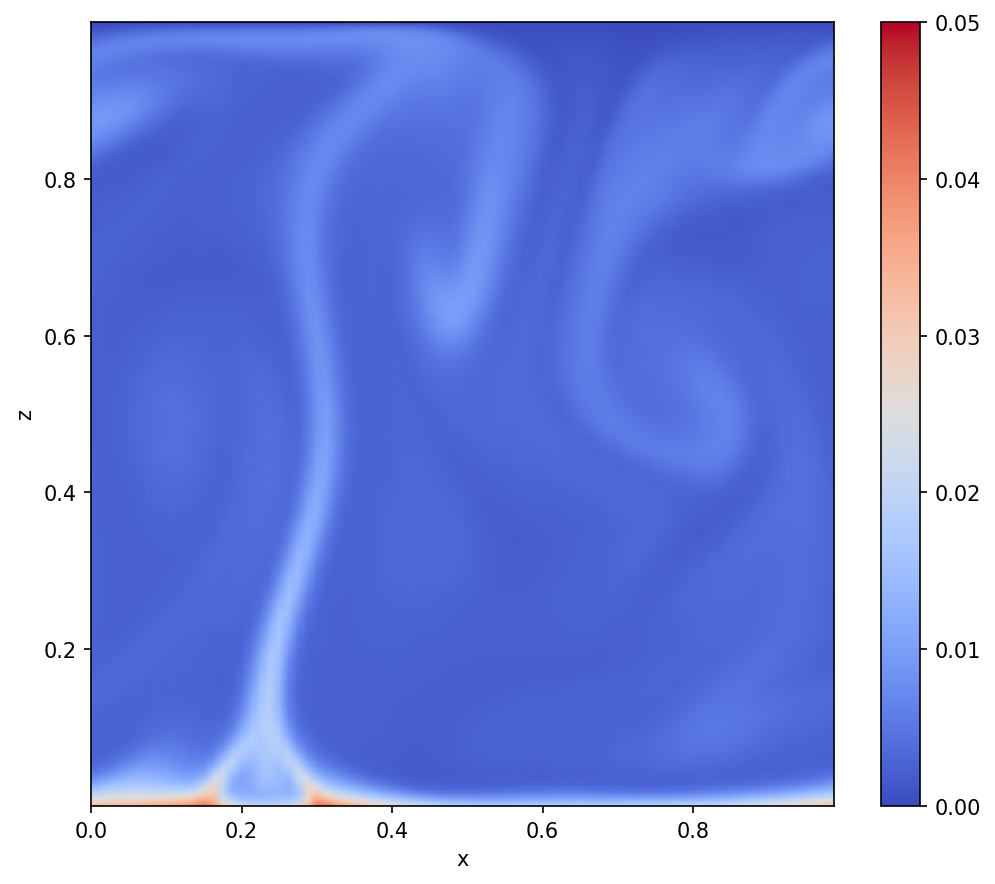

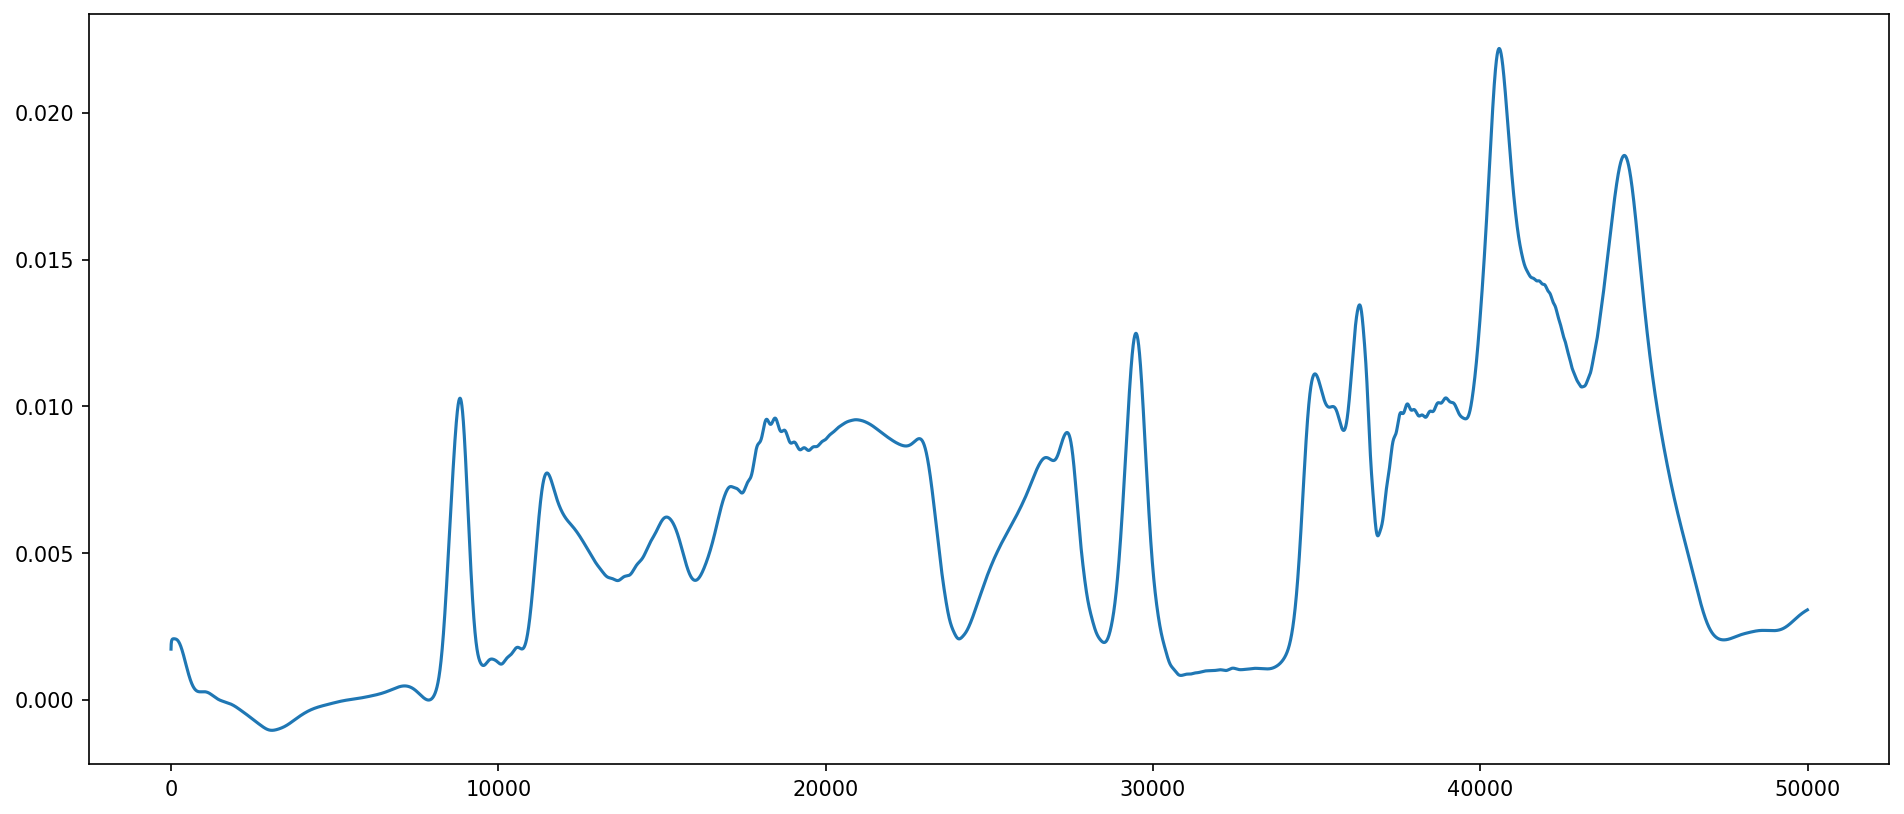

In [12]:
# Results

# Two-dimensional temperature profile

with h5py.File("snapshots/snapshots.h5", mode = 'r') as file:

    # Load datasets
    
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]
    
    fig1 = plt.figure(figsize = (7, 6), dpi = 150)
    quad = plt.pcolormesh(x, z, T[45000].T,shading = 'gouraud',cmap = 'coolwarm',vmin = 0,vmax = 0.5e-1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.tight_layout()
    
#     fig.savefig('2D_RB_temperature_field_timestep20000.jpg',bbox_inches='tight')

    # Animation
    
#     def animate(frame):
#         quad.set_array(frame.T)

#     animation = ani.FuncAnimation(fig, animate, frames=T[-40000:][::50])
#     animation.save('convection.gif',fps=200)

    # Temporal evolution

    fig2 = plt.figure(figsize = (12,5),dpi = 150)
    axes = fig2.add_axes([0, 0, 1, 1])
    axes.plot(T[-50000:,20,20])
    plt.show()
